# Summarize ASSEMBLY level stats & QC across our dataset of 151 Mtb isolates

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [2]:
import json

In [3]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
plt.style.use('./nqo.mplstyle')

## Define paths to sample metadata files

In [7]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"
!mkdir $InputAsmPath_Dir

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"


mkdir: cannot create directory ‘../../Data/231121.InputAsmTSVs.MtbSetV3.151CI’: File exists


## PARSE PATHs FOR ALL assemblies processed by this pipeline

In [8]:
WGA158CI_LRandSR_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")

WGA158CI_LRandSR_Asm_Path_DF.columns = ['SampleID', 'Dataset_Tag',
                                        'Genome_LR_ASM_PATH', 'Genome_SR_ASM_PATH']


In [9]:
WGA158CI_LRandSR_Asm_Path_DF.head(1)

,SampleID,Dataset_Tag,Genome_LR_ASM_PATH,Genome_SR_ASM_PATH
0,N0072,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121...,/n/data1/hms/dbmi/farhat/mm774/Projects/231121...


## Parse sample Metadata (N = 151)

In [10]:

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

#print(','.join(SampleIDs_151CI_SOI) )

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

In [11]:
WGA151CI_AsmSummary_DF.head(3)

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach
0,N0072,1,358,lineage1,"lineage1,lineage1.1,lineage1.1.2",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
1,N0153,1,372,lineage1,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
2,TB3113,1,933,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [12]:
# Define pipeline output directories

Mtb_WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = Mtb_WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


In [13]:
!ls -alh $WGA_SMK_Outputs_Dir

total 16M
drwxr-sr-x 10 mm774 farhat 1.2K Jan 24 10:02 .
drwxrwsr-x 66 mm774 farhat 3.1K Jan 11 23:17 ..
-rw-r--r--  1 mm774 farhat 2.4M Jan 24 10:02 231130.1.Asm.QC.LR.vs.SR.Asms.V1.ipynb
-rw-r--r--  1 mm774 farhat 1.2M Jan 22 15:56 231130.2.SourMash.KmerAnalysis.Parsing.IQTree.V2.ipynb
-rw-r--r--  1 mm774 farhat 344K Jan  3 20:47 231130.3.A.151CI.Minigraph.Nodes.KmerEval.Processing.V1.ipynb
-rw-r--r--  1 mm774 farhat 1.7M Jan 16 11:52 231130.3.C.151CI.Minigraph.Nodes.KmerEval.Analysis.V4.ipynb
-rw-r--r--  1 mm774 farhat 1.4M Jan  8 23:55 231130.3.D.Minigraph.VizTbD1.V1.ipynb
-rw-r--r--  1 mm774 farhat 1.2M Jan 16 13:27 231130.4.A.PGAnalysis.AllParams.Analysis.Try2.ipynb
-rw-r--r--  1 mm774 farhat 1.4M Jan 16 14:06 231130.4.A.PGAnalysis.AllParams.Processing.Try3.ipynb
-rw-r--r--  1 mm774 farhat 853K Jan 19 18:11 231130.4.B.PGAnalysis.AllParams.Explore.V1.ipynb
-rw-r--r--  1 mm774 farhat 168K Jan  4 16:47 231130.5.BaktaVsPGAP.AnnoCountComp.151CI.Try1.ipynb
-rw-r--r--  1 mm774 farhat  4

## Define paths to all BAKTA Annotations (Short + Long read ASMs)

In [14]:
listOfSample_Tags = WGA151CI_SampleIDs

target_SMK_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

SampleTag_ToPaths_Dict = {}

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = target_SMK_OutputDir + "/AsmAnalysis/" + SampleID
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"
    
    # LR Bakta Anno Files
    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    
    i_LRAsm_Bakta_GFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3"
    i_LRAsm_Bakta_GBFF = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff"
    i_LRAsm_Bakta_FAA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa"
    i_LRAsm_Bakta_FFN = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn"
    i_LRAsm_Bakta_FNA = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna"
    i_LRAsm_Bakta_TXT = f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt"

    # SR Bakta Anno Files
    Bakta_SR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_SR_Asm_Bakta"

    i_SRAsm_Bakta_GFF = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3"
    i_SRAsm_Bakta_GBFF = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff"
    i_SRAsm_Bakta_FAA = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa"
    i_SRAsm_Bakta_FFN = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn"
    i_SRAsm_Bakta_FNA = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna"
    i_SRAsm_Bakta_TXT = f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt"

    
    MM2_AsmToRef_Output_Dir = sample_Asm_OutputDir + "/VariantCallingVersusH37Rv/MM2_AsmToH37rv"
    MM2_AsmToH37Rv_BAM = f"{MM2_AsmToRef_Output_Dir}/{SampleID}.mm2.AsmToH37Rv.bam"
    
    dictOfPaths_Temp = {}
    dictOfPaths_Temp["LRAsm_Bakta_GFF"] = i_LRAsm_Bakta_GFF  
    dictOfPaths_Temp["LRAsm_Bakta_GBFF"] = i_LRAsm_Bakta_GBFF
    dictOfPaths_Temp["LRAsm_Bakta_FAA"] = i_LRAsm_Bakta_FAA    
    dictOfPaths_Temp["LRAsm_Bakta_FFN"] = i_LRAsm_Bakta_FFN    
    dictOfPaths_Temp["LRAsm_Bakta_FNA"] = i_LRAsm_Bakta_FNA  
    dictOfPaths_Temp["LRAsm_Bakta_TXT"] = i_LRAsm_Bakta_TXT 

    
    dictOfPaths_Temp["SRAsm_Bakta_GFF"] = i_SRAsm_Bakta_GFF
    dictOfPaths_Temp["SRAsm_Bakta_GBFF"] = i_SRAsm_Bakta_GBFF
    dictOfPaths_Temp["SRAsm_Bakta_FAA"] = i_SRAsm_Bakta_FAA
    dictOfPaths_Temp["SRAsm_Bakta_FFN"] = i_SRAsm_Bakta_FFN
    dictOfPaths_Temp["SRAsm_Bakta_FNA"] = i_SRAsm_Bakta_FNA
    dictOfPaths_Temp["SRAsm_Bakta_TXT"] = i_SRAsm_Bakta_TXT 

    dictOfPaths_Temp["MM2_AsmToH37Rv_BAM"] = MM2_AsmToH37Rv_BAM    
    
    SampleTag_ToPaths_Dict[SampleID] = dictOfPaths_Temp



In [15]:
#SampleTag_ToPaths_Dict[SampleID]

In [16]:
#!ls -1 $Bakta_AsmDir

In [17]:
#list(SampleTag_ToPaths_Dict.keys())

In [18]:
def read_BaktaTXT_ToBasicInfoDict(i_BaktaInfo_TXT):
    """
    Function to read in a bakta.txt file. 
    
    The function extracts the following information & stores it as a dictionary:
    1) Total Cumulative Length (Across all contigs), 2) Number of contigs
    3) GC content, 4) Assembly N50, 5) Number CDS, 6) Coding Density
    """
    
    out_BaktaInfo_Dict = {}
    
    i_Asm_BaktaInfo_DF = pd.read_csv(i_BaktaInfo_TXT, sep = ":",header=None)
    i_Asm_BaktaInfo_RawDict = dict(i_Asm_BaktaInfo_DF[[0,1]].values)

    out_BaktaInfo_Dict["TotalContigLength"] = int(i_Asm_BaktaInfo_RawDict["Length"])
    out_BaktaInfo_Dict["NumContigs"] = int(i_Asm_BaktaInfo_RawDict["Count"])
    out_BaktaInfo_Dict["GCcontent"] = float(i_Asm_BaktaInfo_RawDict["GC"] )
    out_BaktaInfo_Dict["N50"] = float(i_Asm_BaktaInfo_RawDict["N50"])
    out_BaktaInfo_Dict["NumCDS"] = int( i_Asm_BaktaInfo_RawDict["CDSs"])

    out_BaktaInfo_Dict["CodingDensity"] = float(i_Asm_BaktaInfo_RawDict["coding density"])
    out_BaktaInfo_Dict["NumHypotheticals"] = int(i_Asm_BaktaInfo_RawDict['hypotheticals'])

    
    return out_BaktaInfo_Dict


# Parse & Summarize assembly info (LR vs SR)

In [19]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

listOf_SampleInfoTuples = []

listOf_SampleInfoTuplesTidy = []

for i, row in tqdm( WGA158CI_LRandSR_Asm_Path_DF.iterrows() ):  #["RW-TB008"]
    
    SampleID = row["SampleID"]
    
    i_Dataset_Tag = row["Dataset_Tag"]
    i_Asm_FA_PATH = row["Genome_LR_ASM_PATH"]
    
    Sample_Asm_OutDir = f"{target_OutputDir}/AsmAnalysis/{SampleID}"

    #### Lineage Calling #####    
    LineageCall_Dir = f"{Sample_Asm_OutDir}/LineageCalling"
    Paftools_LinCall_Dir = f"{LineageCall_Dir}/LinCall_Paftools_AsmToH37Rv"
    Paftools_LinCall_TSV_PATH = f"{Paftools_LinCall_Dir}/{SampleID}.AsmToH37Rv.lineage_call.tsv"

    Paftools_Lineage_DF = pd.read_csv(Paftools_LinCall_TSV_PATH, sep = "\t")
    LineageCall_coll2014 = str(Paftools_Lineage_DF["coll2014"].values[0])

    if (SampleID == "RW-TB008") and (LineageCall_coll2014 == "nan"): LineageCall_coll2014 = "lineage8"

    ### Busco stats
    
    i_LR_BuscoOut_JSON_PATH = f"{Sample_Asm_OutDir}/Assembly_QC/Busco_Mtb_LRAsm/{SampleID}/short_summary.specific.corynebacteriales_odb10.{SampleID}.json"

    with open(i_LR_BuscoOut_JSON_PATH, 'r') as i_LR_BuscoOut_JSON:
        Coryne_odb10_BuscoResults_Dict = json.load(i_LR_BuscoOut_JSON)

        i_LR_Busco_Complete_Score = float(Coryne_odb10_BuscoResults_Dict["results"]["Complete"])
   
    i_SR_BuscoOut_JSON_PATH = f"{Sample_Asm_OutDir}/Assembly_QC/Busco_Mtb_SRAsm/{SampleID}/short_summary.specific.corynebacteriales_odb10.{SampleID}.json"

    with open(i_SR_BuscoOut_JSON_PATH, 'r') as i_SR_BuscoOut_JSON:
        Coryne_odb10_BuscoResults_Dict = json.load(i_SR_BuscoOut_JSON)

        i_SR_Busco_Complete_Score = float(Coryne_odb10_BuscoResults_Dict["results"]["Complete"])
   
    
        
    #### LR & SR Genome Annotation #####    
    
    i_LRAsm_BaktaInfo_TXT = SampleTag_ToPaths_Dict[SampleID]["LRAsm_Bakta_TXT"]
    i_SRAsm_BaktaInfo_TXT = SampleTag_ToPaths_Dict[SampleID]["SRAsm_Bakta_TXT"]

    i_LRAsm_BaktaInfo_Dict = read_BaktaTXT_ToBasicInfoDict(i_LRAsm_BaktaInfo_TXT)

    LRAsm_TotalLen = i_LRAsm_BaktaInfo_Dict["TotalContigLength"] 
    LRAsm_Ncontigs = i_LRAsm_BaktaInfo_Dict["NumContigs"]
    LRAsm_GCcontent = i_LRAsm_BaktaInfo_Dict["GCcontent"]
    LRAsm_N50 = i_LRAsm_BaktaInfo_Dict["N50"]
    LRAsm_NumCDS = i_LRAsm_BaktaInfo_Dict["NumCDS"]

    i_SRAsm_BaktaInfo_Dict = read_BaktaTXT_ToBasicInfoDict(i_SRAsm_BaktaInfo_TXT)
    SRAsm_TotalLen = i_SRAsm_BaktaInfo_Dict["TotalContigLength"] 
    SRAsm_Ncontigs = i_SRAsm_BaktaInfo_Dict["NumContigs"]
    SRAsm_GCcontent = i_SRAsm_BaktaInfo_Dict["GCcontent"]
    SRAsm_N50 = i_SRAsm_BaktaInfo_Dict["N50"]
    SRAsm_NumCDS = i_SRAsm_BaktaInfo_Dict["NumCDS"]

    SRAsm_CodingDensity = i_SRAsm_BaktaInfo_Dict["CodingDensity"]

    
    sampleInfo_Tuple = (SampleID,
                        i_Dataset_Tag,
                        LineageCall_coll2014,
                        i_LR_Busco_Complete_Score,
                        LRAsm_TotalLen,
                        LRAsm_Ncontigs,
                        LRAsm_GCcontent,
                        LRAsm_N50,
                        LRAsm_NumCDS,
                        i_SR_Busco_Complete_Score,
                        SRAsm_TotalLen,
                        SRAsm_Ncontigs,
                        SRAsm_GCcontent,
                        SRAsm_N50,
                        SRAsm_NumCDS,)
    
    listOf_SampleInfoTuples.append(sampleInfo_Tuple)

    
    sampleInfo_TupleTidy_SR = (SampleID,
                        i_Dataset_Tag,
                        LineageCall_coll2014,
                        "LongRead",
                        i_LR_Busco_Complete_Score,
                        LRAsm_TotalLen,
                        LRAsm_Ncontigs,
                        LRAsm_GCcontent,
                        LRAsm_N50,
                        LRAsm_NumCDS )

    sampleInfo_TupleTidy_LR = (SampleID,
                               i_Dataset_Tag,
                               LineageCall_coll2014,
                               "ShortRead",
                               i_SR_Busco_Complete_Score,
                               SRAsm_TotalLen,
                               SRAsm_Ncontigs,
                               SRAsm_GCcontent,
                               SRAsm_N50,
                               SRAsm_NumCDS,)
    
    
    listOf_SampleInfoTuplesTidy.append(sampleInfo_TupleTidy_LR)
    listOf_SampleInfoTuplesTidy.append(sampleInfo_TupleTidy_SR)
    
    
    
    
    
AsmSummary_DF = pd.DataFrame(listOf_SampleInfoTuples)
AsmSummary_DF.columns = ["SampleID",
                         "Dataset_Tag",
                         "Lineage_coll2014",
                         "LRAsm_Busco_Complete_Score",
                        "LRAsm_TotalLen",
                        "LRAsm_Ncontigs",
                        "LRAsm_GCcontent",
                        "LRAsm_N50",
                        "LRAsm_NumCDS",
                         "SRAsm_Busco_Complete_Score",
                        "SRAsm_TotalLen",
                        "SRAsm_Ncontigs",
                        "SRAsm_GCcontent",
                        "SRAsm_N50",
                        "SRAsm_NumCDS",]

AsmSummary_DF["PrimaryLineage_coll2014"] = AsmSummary_DF["Lineage_coll2014"].str.split(".").str[0]
#AsmSummary_DF["PrimaryLineage_coll2014"] = AsmSummary_DF["PrimaryLineage_coll2014"].str.split(",").str[0]


WGA151CI_Asm_LRvsSR_DF = AsmSummary_DF
WGA151CI_Asm_LRvsSR_DF.shape


WGA151CI_Asm_LRvsSR_TidyDF = pd.DataFrame(listOf_SampleInfoTuplesTidy)
WGA151CI_Asm_LRvsSR_TidyDF.columns = ["SampleID",
                                      "Dataset_Tag",
                                      "Lineage_coll2014",
                                      "AsmType",
                                      "Busco_Complete_Score",
                                      "Asm_TotalLen",
                                      "Asm_Ncontigs",
                                      "Asm_GCcontent",
                                      "Asm_N50",
                                      "Asm_NumCDS",]

WGA151CI_Asm_LRvsSR_TidyDF["PrimaryLineage_coll2014"] = WGA151CI_Asm_LRvsSR_TidyDF["Lineage_coll2014"].str.split(".").str[0]


151it [00:04, 34.57it/s]


In [20]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/AsmAnalysis/N0072/Assembly_QC/


Busco_Mtb_LRAsm
Busco_Mtb_SRAsm


## Output Asm QC Stats to directory

In [21]:
Repo_DataDir = "../../Data"

AsmSummary_TSVs_Dir = Repo_DataDir + "/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs"    
!mkdir $AsmSummary_TSVs_Dir

WGA151CI_AsmQCSumm_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv"
WGA151CI_AsmQC_Tidy_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv"

WGA151CI_Asm_LRvsSR_DF.to_csv(WGA151CI_AsmQCSumm_TSV, sep="\t", index=False)

WGA151CI_Asm_LRvsSR_TidyDF.to_csv(WGA151CI_AsmQC_Tidy_TSV, sep="\t", index=False)

mkdir: cannot create directory ‘../../Data/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs’: File exists


In [22]:
!wc -l $WGA151CI_AsmQCSumm_TSV $WGA151CI_AsmQC_Tidy_TSV

  152 ../../Data/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv
  303 ../../Data/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv
  455 total


In [23]:
!mkdir ./Data/AsmInfo
AsmSummary_TSVs_Dir = "./Data/AsmInfo" + "/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs"    
!mkdir $AsmSummary_TSVs_Dir

WGA151CI_AsmQCSumm_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.tsv"
WGA151CI_AsmQC_Tidy_TSV = f"{AsmSummary_TSVs_Dir}/231130.WGA158CI.LRvsSR.AsmQC.V1.Tidy.tsv"

WGA151CI_Asm_LRvsSR_DF.to_csv(WGA151CI_AsmQCSumm_TSV, sep="\t", index=False)

WGA151CI_Asm_LRvsSR_TidyDF.to_csv(WGA151CI_AsmQC_Tidy_TSV, sep="\t", index=False)

mkdir: cannot create directory ‘./Data/AsmInfo’: File exists
mkdir: cannot create directory ‘./Data/AsmInfo/231130_WGA-Mtb_CompleteVsSR_AsmSummary_TSVs’: File exists


In [24]:
WGA158CI_Asm_LRvsSR_TidyDF = WGA151CI_Asm_LRvsSR_TidyDF
WGA158CI_Asm_LRvsSR_DF = WGA151CI_Asm_LRvsSR_DF

## Explore Asm Stats

In [25]:
WGA151CI_Asm_LRvsSR_DF.head(5)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
0,N0072,ChinerOms_2019,lineage1.1.2,99.3,4421404,1,65.6,4421404.0,4051,99.3,4353633,104,65.5,120698.0,4064,lineage1
1,N0153,ChinerOms_2019,lineage1.1.1.1,99.4,4389181,1,65.6,4389181.0,4041,99.0,4331132,116,65.5,90314.0,4048,lineage1
2,TB3113,TB_Portals_24CI_R1,lineage2.2.1,99.4,4419922,1,65.6,4419922.0,4083,99.3,4332706,114,65.6,93741.0,4058,lineage2
3,TB1236,TB_Portals_24CI_R1,lineage2.2.1,99.3,4413161,1,65.6,4413161.0,4072,99.6,4333175,123,65.6,93845.0,4066,lineage2
4,TB2659,TB_Portals_24CI_R1,lineage2.2.1,99.3,4413335,1,65.6,4413335.0,4072,99.4,4337975,113,65.6,105302.0,4039,lineage2


In [26]:
WGA151CI_Asm_LRvsSR_DF.tail(5)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
146,S0089-01,TRUST_PB_Set1,lineage2.2.1.1,99.4,4415289,1,65.6,4415289.0,4072,99.6,4342798,107,65.6,104744.0,4042,lineage2
147,S0256-08,TRUST_PB_Set1,lineage2.2.1.1,99.4,4413248,1,65.6,4413248.0,4072,99.6,4340583,108,65.6,113484.0,4029,lineage2
148,S0123-01,TRUST_PB_Set1,lineage4.4.1.1,99.6,4402641,1,65.6,4402641.0,4062,99.6,4341428,91,65.6,130052.0,4037,lineage4
149,S0106-01,TRUST_PB_Set1,lineage4.1.1.3,99.6,4412324,1,65.6,4412324.0,4051,99.6,4367135,83,65.6,152312.0,4029,lineage4
150,S0262-02,TRUST_PB_Set1,lineage4.4.1.1,99.6,4402641,1,65.6,4402641.0,4062,99.6,4340688,96,65.6,125379.0,4038,lineage4


In [27]:
WGA151CI_Asm_LRvsSR_DF.query("SampleID == 'mada_1-38' ")

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
142,mada_1-38,Hall2022,lineage4.9,99.2,4416386,1,65.6,4416386.0,4087,98.8,4266244,165,65.4,57709.0,4015,lineage4


In [28]:
WGA151CI_Asm_LRvsSR_DF.query("PrimaryLineage_coll2014 == 'lineage8' ")

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
47,RW-TB008,Ngabonziza_Lin8_2020,lineage8,98.9,4379891,1,65.6,4379891.0,4073,96.9,4247417,105,65.5,87845.0,3992,lineage8


In [29]:
WGA151CI_Asm_LRvsSR_DF.sort_values("SRAsm_TotalLen", ascending = False).head(10)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
33,TB3251,TB_Portals_24CI_R1,lineage4.2.1,99.6,4438319,1,65.6,4438319.0,4096,99.6,4374270,103,65.6,125225.0,4060,lineage4
31,MT_0080,Lee2020_Elife,lineage4.1.2,99.5,4426547,1,65.6,4426547.0,4079,99.6,4369593,104,65.6,130438.0,4019,lineage4
149,S0106-01,TRUST_PB_Set1,lineage4.1.1.3,99.6,4412324,1,65.6,4412324.0,4051,99.6,4367135,83,65.6,152312.0,4029,lineage4
34,M0016737_0,Farhat_Peru_2019,lineage4.5,99.3,4431508,1,65.6,4431508.0,4102,99.4,4365608,98,65.6,105878.0,4048,lineage4
21,M0017522_5,Farhat_Peru_2019,lineage4.1.1,99.6,4416715,1,65.6,4416715.0,4063,99.6,4361556,119,65.6,105693.0,4044,lineage4
17,N1274,ChinerOms_2019,lineage3,99.6,4439091,1,65.6,4439091.0,4098,99.2,4357916,117,65.5,80128.0,4080,lineage3
0,N0072,ChinerOms_2019,lineage1.1.2,99.3,4421404,1,65.6,4421404.0,4051,99.3,4353633,104,65.5,120698.0,4064,lineage1
76,R27252,Hall2022,lineage1.2.2,99.6,4431372,1,65.6,4431372.0,4105,99.6,4353052,110,65.5,84311.0,4068,lineage1
32,TB3054,TB_Portals_24CI_R1,lineage4.6.2,99.6,4415465,1,65.6,4415465.0,4073,99.3,4351713,90,65.6,136573.0,4046,lineage4
144,S0085-01,TRUST_PB_Set1,lineage2.2.1.1,99.4,4417384,1,65.6,4417384.0,4074,99.4,4349407,114,65.6,98884.0,4036,lineage2


In [30]:
WGA151CI_Asm_LRvsSR_DF.sort_values("SRAsm_Busco_Complete_Score", ascending = True).head(8)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
115,R21770,Hall2022,lineage4.1.1.3,99.5,4410459,1,65.6,4410459.0,4059,90.8,4140485,374,65.6,21940.0,3967,lineage4
91,R25048,Hall2022,lineage2.2.1,99.0,4417435,1,65.6,4417435.0,4092,94.1,4027491,274,65.8,24563.0,3862,lineage2
62,QC-7,Peker2021,lineage4.3,98.6,4397872,1,65.6,4397872.0,4082,95.8,4208044,139,65.5,60844.0,3923,lineage4
28,02_R1896,Farhat_Peru_2019,lineage4.4.1.1,99.6,4407304,1,65.6,4407304.0,4074,96.1,4262729,104,65.5,114451.0,3967,lineage4
45,N1177,ChinerOms_2019,"lineage6,lineageBOV_AFRI",99.2,4385023,1,65.6,4385023.0,4020,96.3,4182467,255,65.3,27030.0,3979,"lineage6,lineageBOV_AFRI"
47,RW-TB008,Ngabonziza_Lin8_2020,lineage8,98.9,4379891,1,65.6,4379891.0,4073,96.9,4247417,105,65.5,87845.0,3992,lineage8
8,TB2981,TB_Portals_24CI_R1,lineage2.2.1,99.4,4419941,1,65.6,4419941.0,4081,97.5,4303268,107,65.6,95093.0,4009,lineage2
43,N1176,ChinerOms_2019,lineage5,99.4,4426379,1,65.6,4426379.0,4083,97.9,4314710,141,65.5,67877.0,4046,lineage5


In [31]:
WGA151CI_Asm_LRvsSR_DF.sort_values("SRAsm_TotalLen", ascending = False).head(8)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
33,TB3251,TB_Portals_24CI_R1,lineage4.2.1,99.6,4438319,1,65.6,4438319.0,4096,99.6,4374270,103,65.6,125225.0,4060,lineage4
31,MT_0080,Lee2020_Elife,lineage4.1.2,99.5,4426547,1,65.6,4426547.0,4079,99.6,4369593,104,65.6,130438.0,4019,lineage4
149,S0106-01,TRUST_PB_Set1,lineage4.1.1.3,99.6,4412324,1,65.6,4412324.0,4051,99.6,4367135,83,65.6,152312.0,4029,lineage4
34,M0016737_0,Farhat_Peru_2019,lineage4.5,99.3,4431508,1,65.6,4431508.0,4102,99.4,4365608,98,65.6,105878.0,4048,lineage4
21,M0017522_5,Farhat_Peru_2019,lineage4.1.1,99.6,4416715,1,65.6,4416715.0,4063,99.6,4361556,119,65.6,105693.0,4044,lineage4
17,N1274,ChinerOms_2019,lineage3,99.6,4439091,1,65.6,4439091.0,4098,99.2,4357916,117,65.5,80128.0,4080,lineage3
0,N0072,ChinerOms_2019,lineage1.1.2,99.3,4421404,1,65.6,4421404.0,4051,99.3,4353633,104,65.5,120698.0,4064,lineage1
76,R27252,Hall2022,lineage1.2.2,99.6,4431372,1,65.6,4431372.0,4105,99.6,4353052,110,65.5,84311.0,4068,lineage1


In [32]:
WGA151CI_Asm_LRvsSR_TidyDF.query("SampleID == 'N0072' ")

,SampleID,Dataset_Tag,Lineage_coll2014,AsmType,Busco_Complete_Score,Asm_TotalLen,Asm_Ncontigs,Asm_GCcontent,Asm_N50,Asm_NumCDS,PrimaryLineage_coll2014
0,N0072,ChinerOms_2019,lineage1.1.2,ShortRead,99.3,4353633,104,65.5,120698.0,4064,lineage1
1,N0072,ChinerOms_2019,lineage1.1.2,LongRead,99.3,4421404,1,65.6,4421404.0,4051,lineage1


In [33]:
WGA151CI_Asm_LRvsSR_DF["LRAsm_TotalLen"].describe()

count    1.510000e+02
mean     4.412729e+06
std      1.103503e+04
min      4.379891e+06
25%      4.407116e+06
50%      4.413185e+06
75%      4.420762e+06
max      4.439091e+06
Name: LRAsm_TotalLen, dtype: float64

In [34]:
WGA151CI_Asm_LRvsSR_DF["SRAsm_TotalLen"].describe()

count    1.510000e+02
mean     4.308387e+06
std      4.100473e+04
min      4.027491e+06
25%      4.289080e+06
50%      4.314468e+06
75%      4.335781e+06
max      4.374270e+06
Name: SRAsm_TotalLen, dtype: float64

# Compare high-level assembly stats across ALL isolates (N = 151)

#### Peak at DFs

In [35]:
WGA151CI_Asm_LRvsSR_DF.head(5)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
0,N0072,ChinerOms_2019,lineage1.1.2,99.3,4421404,1,65.6,4421404.0,4051,99.3,4353633,104,65.5,120698.0,4064,lineage1
1,N0153,ChinerOms_2019,lineage1.1.1.1,99.4,4389181,1,65.6,4389181.0,4041,99.0,4331132,116,65.5,90314.0,4048,lineage1
2,TB3113,TB_Portals_24CI_R1,lineage2.2.1,99.4,4419922,1,65.6,4419922.0,4083,99.3,4332706,114,65.6,93741.0,4058,lineage2
3,TB1236,TB_Portals_24CI_R1,lineage2.2.1,99.3,4413161,1,65.6,4413161.0,4072,99.6,4333175,123,65.6,93845.0,4066,lineage2
4,TB2659,TB_Portals_24CI_R1,lineage2.2.1,99.3,4413335,1,65.6,4413335.0,4072,99.4,4337975,113,65.6,105302.0,4039,lineage2


In [36]:
WGA151CI_Asm_LRvsSR_TidyDF.head(5)

,SampleID,Dataset_Tag,Lineage_coll2014,AsmType,Busco_Complete_Score,Asm_TotalLen,Asm_Ncontigs,Asm_GCcontent,Asm_N50,Asm_NumCDS,PrimaryLineage_coll2014
0,N0072,ChinerOms_2019,lineage1.1.2,ShortRead,99.3,4353633,104,65.5,120698.0,4064,lineage1
1,N0072,ChinerOms_2019,lineage1.1.2,LongRead,99.3,4421404,1,65.6,4421404.0,4051,lineage1
2,N0153,ChinerOms_2019,lineage1.1.1.1,ShortRead,99.0,4331132,116,65.5,90314.0,4048,lineage1
3,N0153,ChinerOms_2019,lineage1.1.1.1,LongRead,99.4,4389181,1,65.6,4389181.0,4041,lineage1
4,TB3113,TB_Portals_24CI_R1,lineage2.2.1,ShortRead,99.3,4332706,114,65.6,93741.0,4058,lineage2


In [37]:
WGA151CI_Asm_LRvsSR_DF.query("LRAsm_NumCDS == 4135")

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
53,8129-04,Peker2021,lineage2.2.1,99.6,4418664,1,65.6,4418664.0,4135,99.6,4313133,144,65.5,76319.0,4049,lineage2


## What are the high-level characteristics of the Complete (Hybrid LR+SR) Assemblies

In [38]:
WGA151CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,65.60000,2.851629e-14,65.6,65.6,65.6,65.6,65.6
ShortRead,151.0,65.52053,7.942953e-02,65.3,65.5,65.5,65.6,65.8


In [39]:
WGA151CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,4077.370861,18.989687,4020.0,4065.0,4074.0,4088.0,4135.0
ShortRead,151.0,4031.966887,25.823869,3862.0,4022.0,4035.0,4046.0,4080.0


In [40]:
WGA151CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,4.412729e+06,11035.030831,4379891.0,4407115.5,4413185.0,4420762.0,4439091.0
ShortRead,151.0,4.308387e+06,41004.729627,4027491.0,4289080.5,4314468.0,4335781.0,4374270.0


In [41]:
# Complete Genome Size Range: 4.38 - 4.44 Mb
# SR Genome Size Range: 4.03 - 4.37 Mb

## 1) Busco Complete Score - LR vs SR

In [42]:
WGA151CI_Asm_LRvsSR_TidyDF.head(1)

,SampleID,Dataset_Tag,Lineage_coll2014,AsmType,Busco_Complete_Score,Asm_TotalLen,Asm_Ncontigs,Asm_GCcontent,Asm_N50,Asm_NumCDS,PrimaryLineage_coll2014
0,N0072,ChinerOms_2019,lineage1.1.2,ShortRead,99.3,4353633,104,65.5,120698.0,4064,lineage1


In [43]:
WGA151CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Busco_Complete_Score"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,99.409272,0.160562,98.6,99.3,99.4,99.5,99.6
ShortRead,151.0,99.200000,1.010017,90.8,99.3,99.4,99.6,99.6


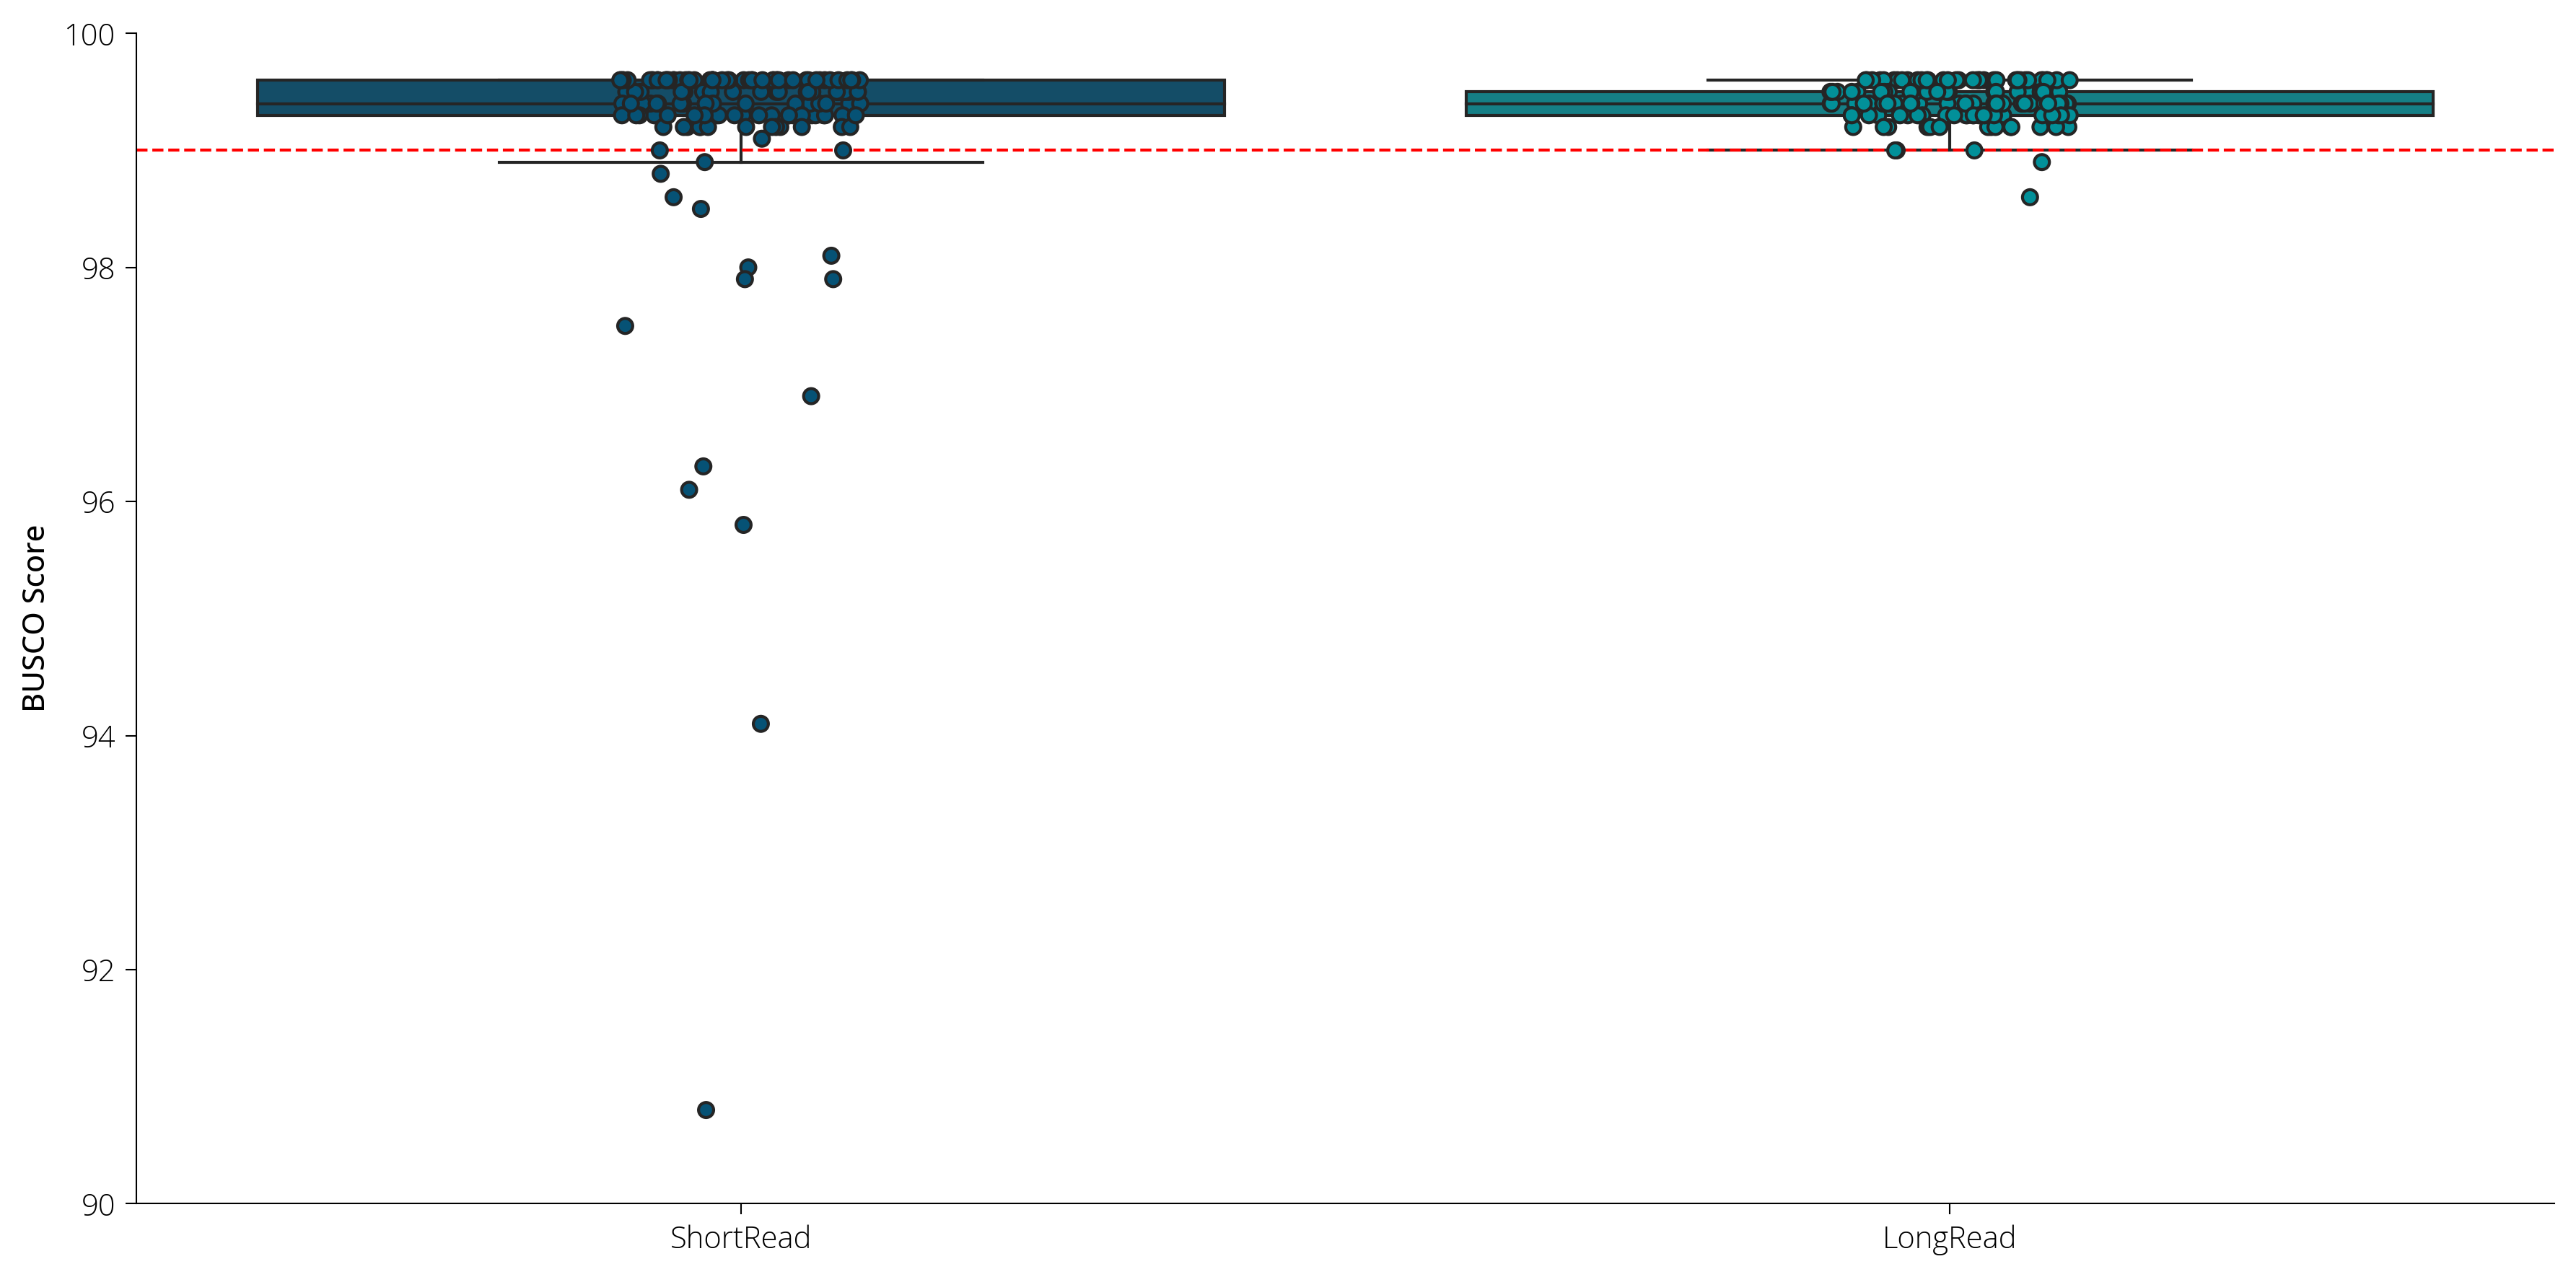

In [44]:

plt.figure(figsize=(12,6))
sns.boxplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA151CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA151CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )

plt.axhline(y = 99.0, color = 'r', linestyle = '--')

sns.despine()
plt.ylabel("BUSCO Score")
plt.xlabel("")
plt.ylim(90, 100)
plt.show()

In [45]:
WGA151CI_Asm_LRvsSR_DF.sort_values("LRAsm_Busco_Complete_Score", ascending=True).head(10)

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
62,QC-7,Peker2021,lineage4.3,98.6,4397872,1,65.6,4397872.0,4082,95.8,4208044,139,65.5,60844.0,3923,lineage4
47,RW-TB008,Ngabonziza_Lin8_2020,lineage8,98.9,4379891,1,65.6,4379891.0,4073,96.9,4247417,105,65.5,87845.0,3992,lineage8
91,R25048,Hall2022,lineage2.2.1,99.0,4417435,1,65.6,4417435.0,4092,94.1,4027491,274,65.8,24563.0,3862,lineage2
74,mada_122,Hall2022,lineage1.1.2,99.0,4422293,1,65.6,4422293.0,4069,99.4,4316342,121,65.5,116280.0,4039,lineage1
136,mada_1-15,Hall2022,lineage4.8,99.0,4432325,1,65.6,4432325.0,4092,99.3,4288589,122,65.4,82740.0,4036,lineage4
93,R28581,Hall2022,lineage2.2.1.1,99.2,4416626,1,65.6,4416626.0,4100,99.5,4285904,138,65.4,69150.0,4030,lineage2
92,R24120,Hall2022,lineage2.2.1,99.2,4423031,1,65.6,4423031.0,4101,99.5,4302995,154,65.5,64011.0,4061,lineage2
42,N1272,ChinerOms_2019,lineage5,99.2,4421126,1,65.6,4421126.0,4090,99.0,4261973,119,65.5,81506.0,4001,lineage5
78,R30215,Hall2022,lineage2.2.1,99.2,4424107,1,65.6,4424107.0,4092,98.9,4286639,139,65.5,69061.0,4054,lineage2
16,N0004,ChinerOms_2019,lineage3,99.2,4423516,1,65.6,4423516.0,4076,99.2,4319932,101,65.6,92078.0,4030,lineage3


In [46]:
i_IDs = ["mada_1-53", "mada_1-40", "R28581", "QC-5", "RW-TB008"]

In [47]:
WGA151CI_Asm_LRvsSR_DF[ WGA151CI_Asm_LRvsSR_DF["SampleID"].isin(i_IDs) ]    

,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
47,RW-TB008,Ngabonziza_Lin8_2020,lineage8,98.9,4379891,1,65.6,4379891.0,4073,96.9,4247417,105,65.5,87845.0,3992,lineage8
58,QC-5,Peker2021,lineage3,99.5,4428080,1,65.6,4428080.0,4114,99.5,4305029,131,65.4,75212.0,4055,lineage3
93,R28581,Hall2022,lineage2.2.1.1,99.2,4416626,1,65.6,4416626.0,4100,99.5,4285904,138,65.4,69150.0,4030,lineage2
138,mada_1-53,Hall2022,lineage4.8,99.3,4400393,1,65.6,4400393.0,4055,99.2,4330562,104,65.6,123675.0,4032,lineage4


In [48]:
WGA158CI_Asm_LRvsSR_DF[["LRAsm_Busco_Complete_Score", "LRAsm_TotalLen", "LRAsm_NumCDS"]].describe()


,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_NumCDS
count,151.000000,1.510000e+02,151.000000
mean,99.409272,4.412729e+06,4077.370861
std,0.160562,1.103503e+04,18.989687
min,98.600000,4.379891e+06,4020.000000
25%,99.300000,4.407116e+06,4065.000000
50%,99.400000,4.413185e+06,4074.000000
75%,99.500000,4.420762e+06,4088.000000
max,99.600000,4.439091e+06,4135.000000


In [49]:
WGA158CI_Asm_LRvsSR_DF.sort_values("LRAsm_Busco_Complete_Score", ascending=True).head(10)          




,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
62,QC-7,Peker2021,lineage4.3,98.6,4397872,1,65.6,4397872.0,4082,95.8,4208044,139,65.5,60844.0,3923,lineage4
47,RW-TB008,Ngabonziza_Lin8_2020,lineage8,98.9,4379891,1,65.6,4379891.0,4073,96.9,4247417,105,65.5,87845.0,3992,lineage8
91,R25048,Hall2022,lineage2.2.1,99.0,4417435,1,65.6,4417435.0,4092,94.1,4027491,274,65.8,24563.0,3862,lineage2
74,mada_122,Hall2022,lineage1.1.2,99.0,4422293,1,65.6,4422293.0,4069,99.4,4316342,121,65.5,116280.0,4039,lineage1
136,mada_1-15,Hall2022,lineage4.8,99.0,4432325,1,65.6,4432325.0,4092,99.3,4288589,122,65.4,82740.0,4036,lineage4
93,R28581,Hall2022,lineage2.2.1.1,99.2,4416626,1,65.6,4416626.0,4100,99.5,4285904,138,65.4,69150.0,4030,lineage2
92,R24120,Hall2022,lineage2.2.1,99.2,4423031,1,65.6,4423031.0,4101,99.5,4302995,154,65.5,64011.0,4061,lineage2
42,N1272,ChinerOms_2019,lineage5,99.2,4421126,1,65.6,4421126.0,4090,99.0,4261973,119,65.5,81506.0,4001,lineage5
78,R30215,Hall2022,lineage2.2.1,99.2,4424107,1,65.6,4424107.0,4092,98.9,4286639,139,65.5,69061.0,4054,lineage2
16,N0004,ChinerOms_2019,lineage3,99.2,4423516,1,65.6,4423516.0,4076,99.2,4319932,101,65.6,92078.0,4030,lineage3


In [50]:
i_IDs = ['mada_1-40', 'mada_117', 'mada_1-51', 'R36431', 'R37765',
       'mada_2-42', 'R28581', 'R29598', 'R24100', 'R30420', 'QC-5',
       'QC-3', 'QC-10', 'mada_139', 'R15311', 'QC-1', '8644-04',
       'mada_1-53', 'R23571', 'mada_1-2']

In [51]:
WGA158CI_Asm_LRvsSR_DF[ WGA158CI_Asm_LRvsSR_DF["SampleID"].isin(i_IDs) ].sort_values("SampleID")  


,SampleID,Dataset_Tag,Lineage_coll2014,LRAsm_Busco_Complete_Score,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_Busco_Complete_Score,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS,PrimaryLineage_coll2014
64,QC-1,Peker2021,lineage4.3.3,99.6,4406927,1,65.6,4406927.0,4090,99.6,4265617,141,65.4,69132.0,3995,lineage4
60,QC-10,Peker2021,lineage4.1.2.1,99.3,4415039,1,65.6,4415039.0,4084,99.3,4298479,121,65.5,81608.0,4024,lineage4
56,QC-3,Peker2021,lineage3,99.5,4427966,1,65.6,4427966.0,4120,99.5,4311713,138,65.4,69238.0,4059,lineage3
58,QC-5,Peker2021,lineage3,99.5,4428080,1,65.6,4428080.0,4114,99.5,4305029,131,65.4,75212.0,4055,lineage3
126,R15311,Hall2022,lineage4.3.2.1,99.5,4411356,1,65.6,4411356.0,4073,99.6,4301755,121,65.5,97681.0,4042,lineage4
133,R23571,Hall2022,lineage4.8,99.3,4401432,1,65.6,4401432.0,4062,99.2,4302433,105,65.5,84579.0,4013,lineage4
96,R24100,Hall2022,lineage2.2.1.1,99.4,4415341,1,65.6,4415341.0,4093,99.2,4275707,158,65.4,57394.0,4037,lineage2
93,R28581,Hall2022,lineage2.2.1.1,99.2,4416626,1,65.6,4416626.0,4100,99.5,4285904,138,65.4,69150.0,4030,lineage2
94,R29598,Hall2022,lineage2.2.1.1,99.3,4413730,1,65.6,4413730.0,4087,99.6,4315119,134,65.5,82386.0,4053,lineage2
105,R30420,Hall2022,lineage2.2.2,99.3,4410553,1,65.6,4410553.0,4088,99.5,4280472,141,65.4,64010.0,4014,lineage2


In [52]:
#sns.boxplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
#sns.stripplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
#plt.axhline(y = 99.0, color = 'r', linestyle = '--')
#plt.ylim(98.5, 100)
#plt.show()

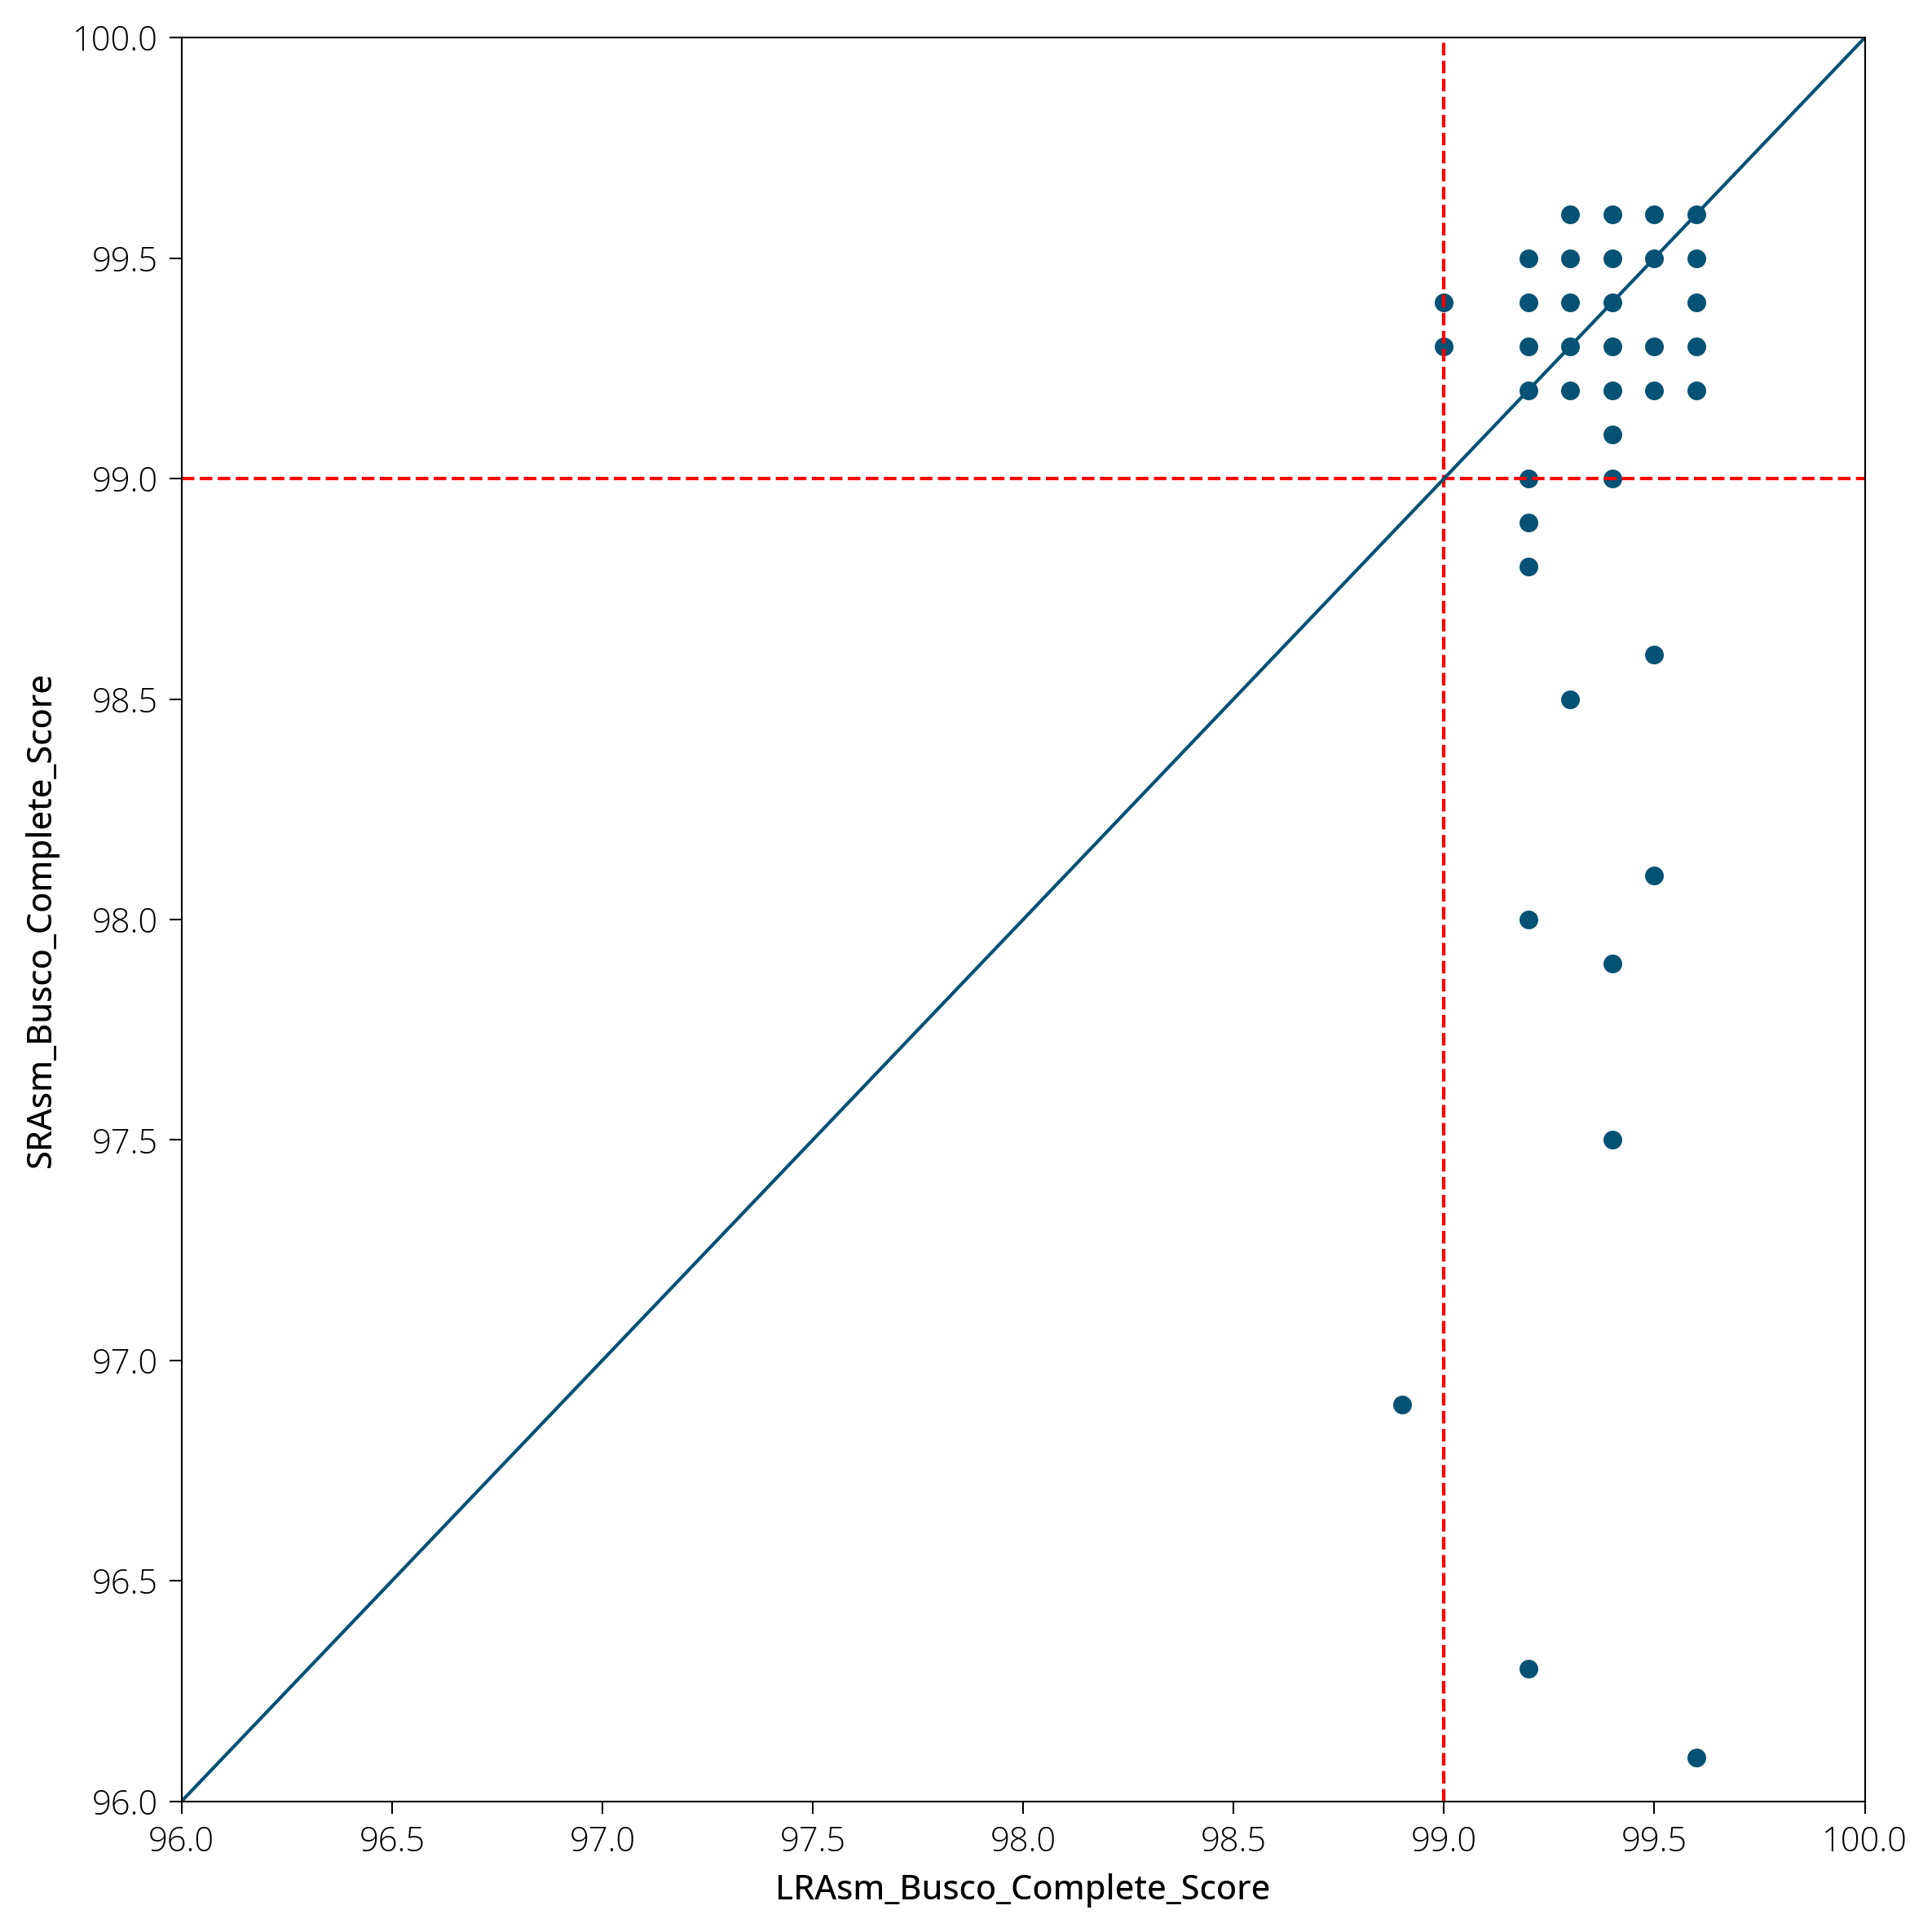

In [53]:
plt.figure(figsize = (8,8)  )

sns.scatterplot(x = "LRAsm_Busco_Complete_Score", y = "SRAsm_Busco_Complete_Score", data = WGA158CI_Asm_LRvsSR_DF)

x = np.linspace(0, 101, 1000)

plt.axhline(y = 99.0, color = 'r', linestyle = '--')
plt.axvline(x = 99.0, color = 'r', linestyle = '--')

plt.plot(x, x)

plt.xlim(96, 100)
plt.ylim(96, 100)

plt.show()

## 2) NumContigs - LR vs SR

In [54]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_Ncontigs"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
ShortRead,151.0,121.807947,33.019331,79.0,105.5,116.0,131.5,374.0


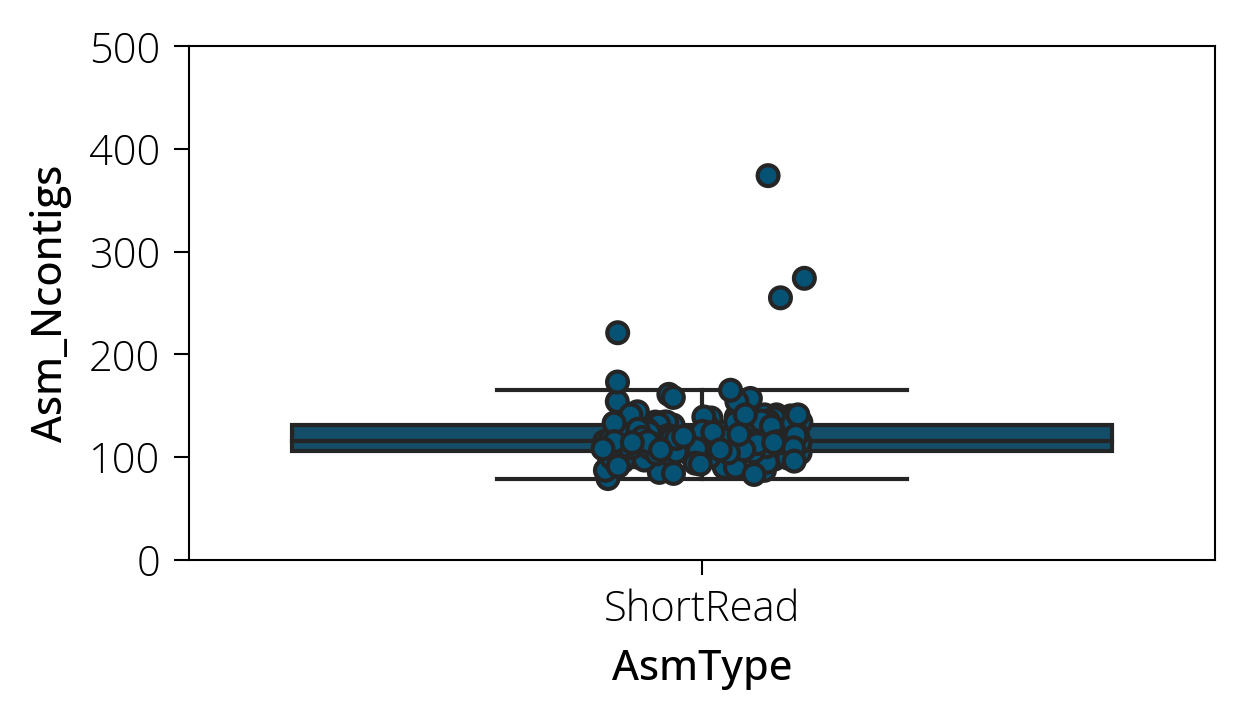

In [55]:
sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), fliersize=0)
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), linewidth=1, edgecolor='gray', )
plt.ylim(0, 500)
plt.show()

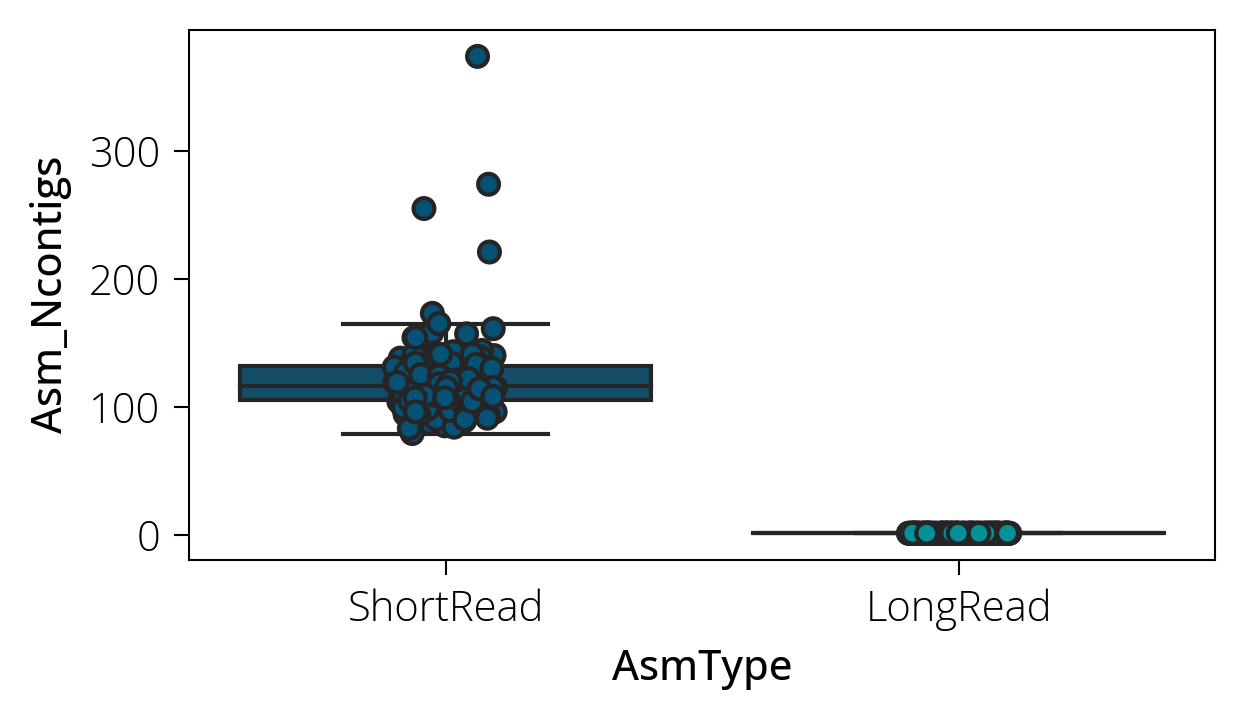

In [56]:
sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
#plt.ylim(0, 400)
plt.show()

## 3) N50 - LR vs SR

In [57]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_N50"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,4.412729e+06,11035.030831,4379891.0,4407115.5,4413185.0,4420762.0,4439091.0
ShortRead,151.0,9.188476e+04,24704.284483,21940.0,73046.5,92078.0,107113.5,161474.0


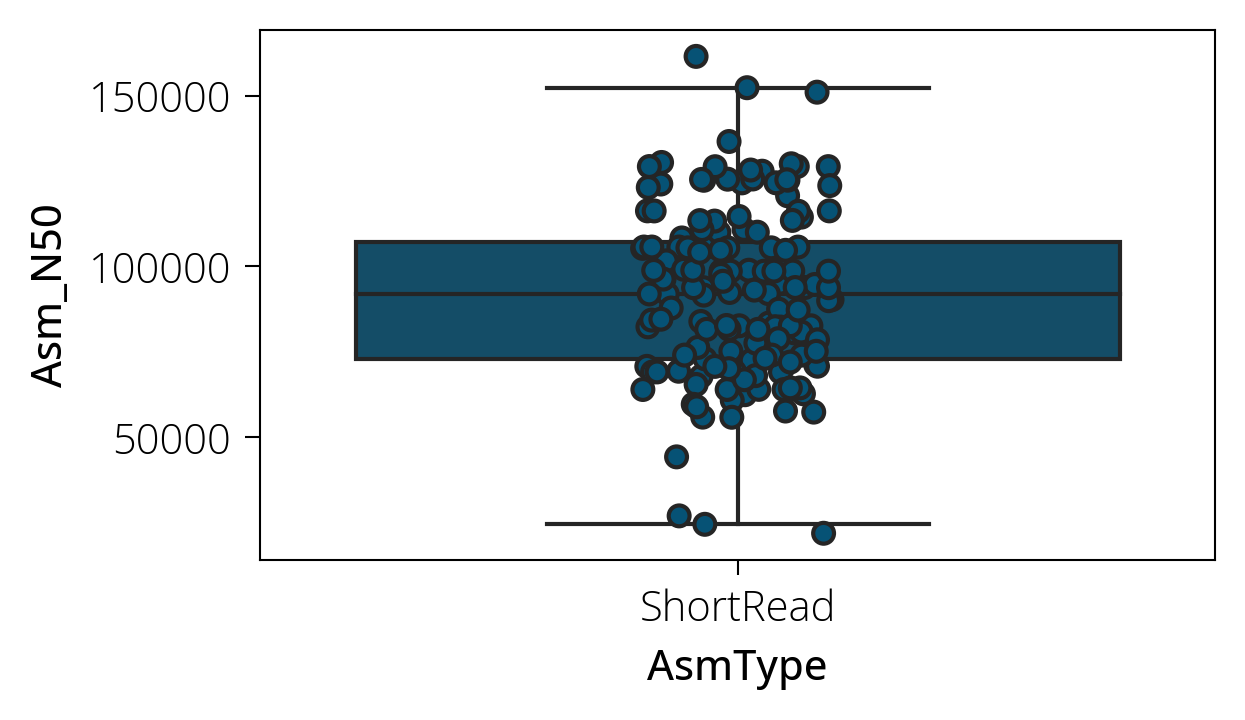

In [58]:
sns.boxplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), fliersize=0)
sns.stripplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), linewidth=1, edgecolor='gray', )
#plt.ylim(0, 5000000)
plt.show()

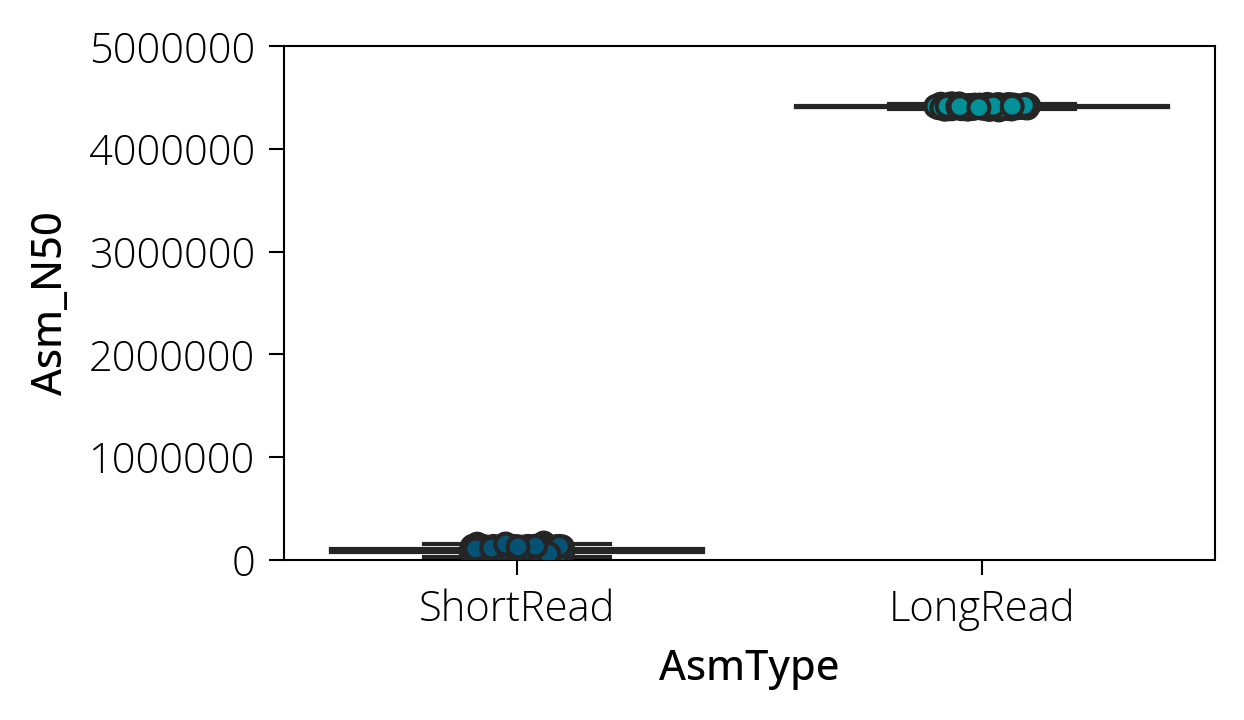

In [59]:
sns.boxplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.ylim(0, 5000000)
plt.show()

## 4) Cumulative length of assembly - LR vs SR

In [60]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,4.412729e+06,11035.030831,4379891.0,4407115.5,4413185.0,4420762.0,4439091.0
ShortRead,151.0,4.308387e+06,41004.729627,4027491.0,4289080.5,4314468.0,4335781.0,4374270.0


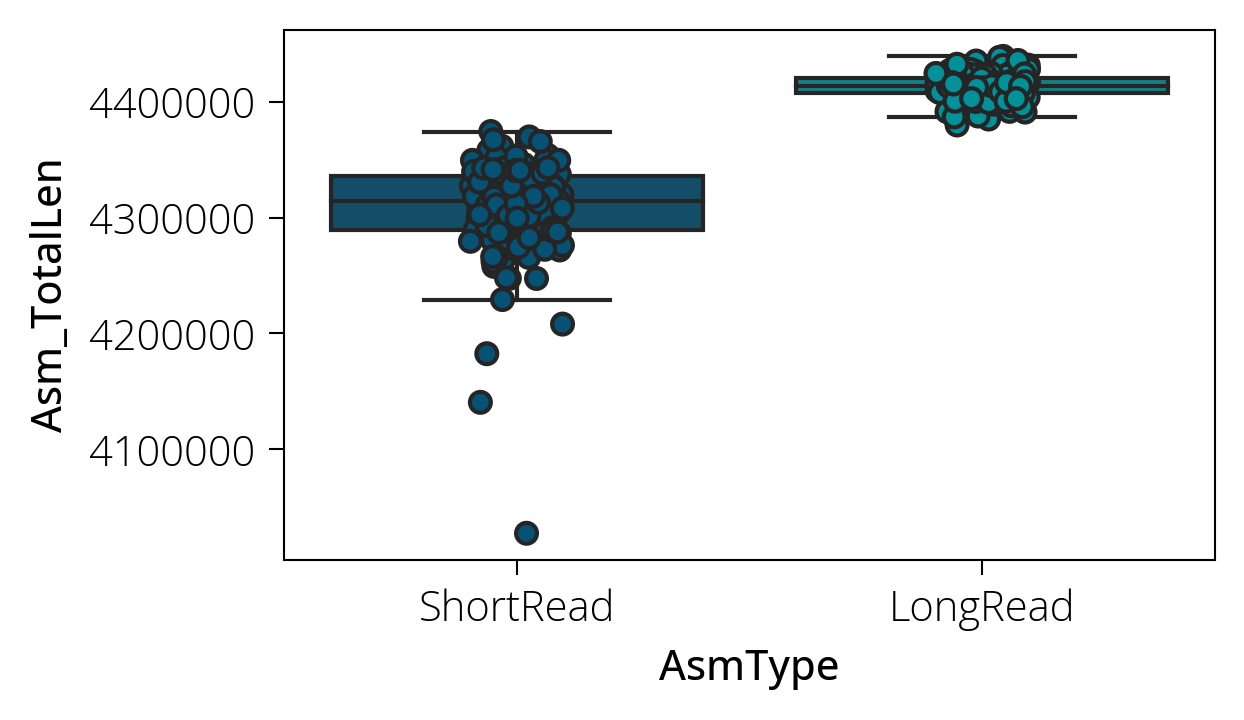

In [61]:
sns.boxplot(y = "Asm_TotalLen", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_TotalLen", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.show()

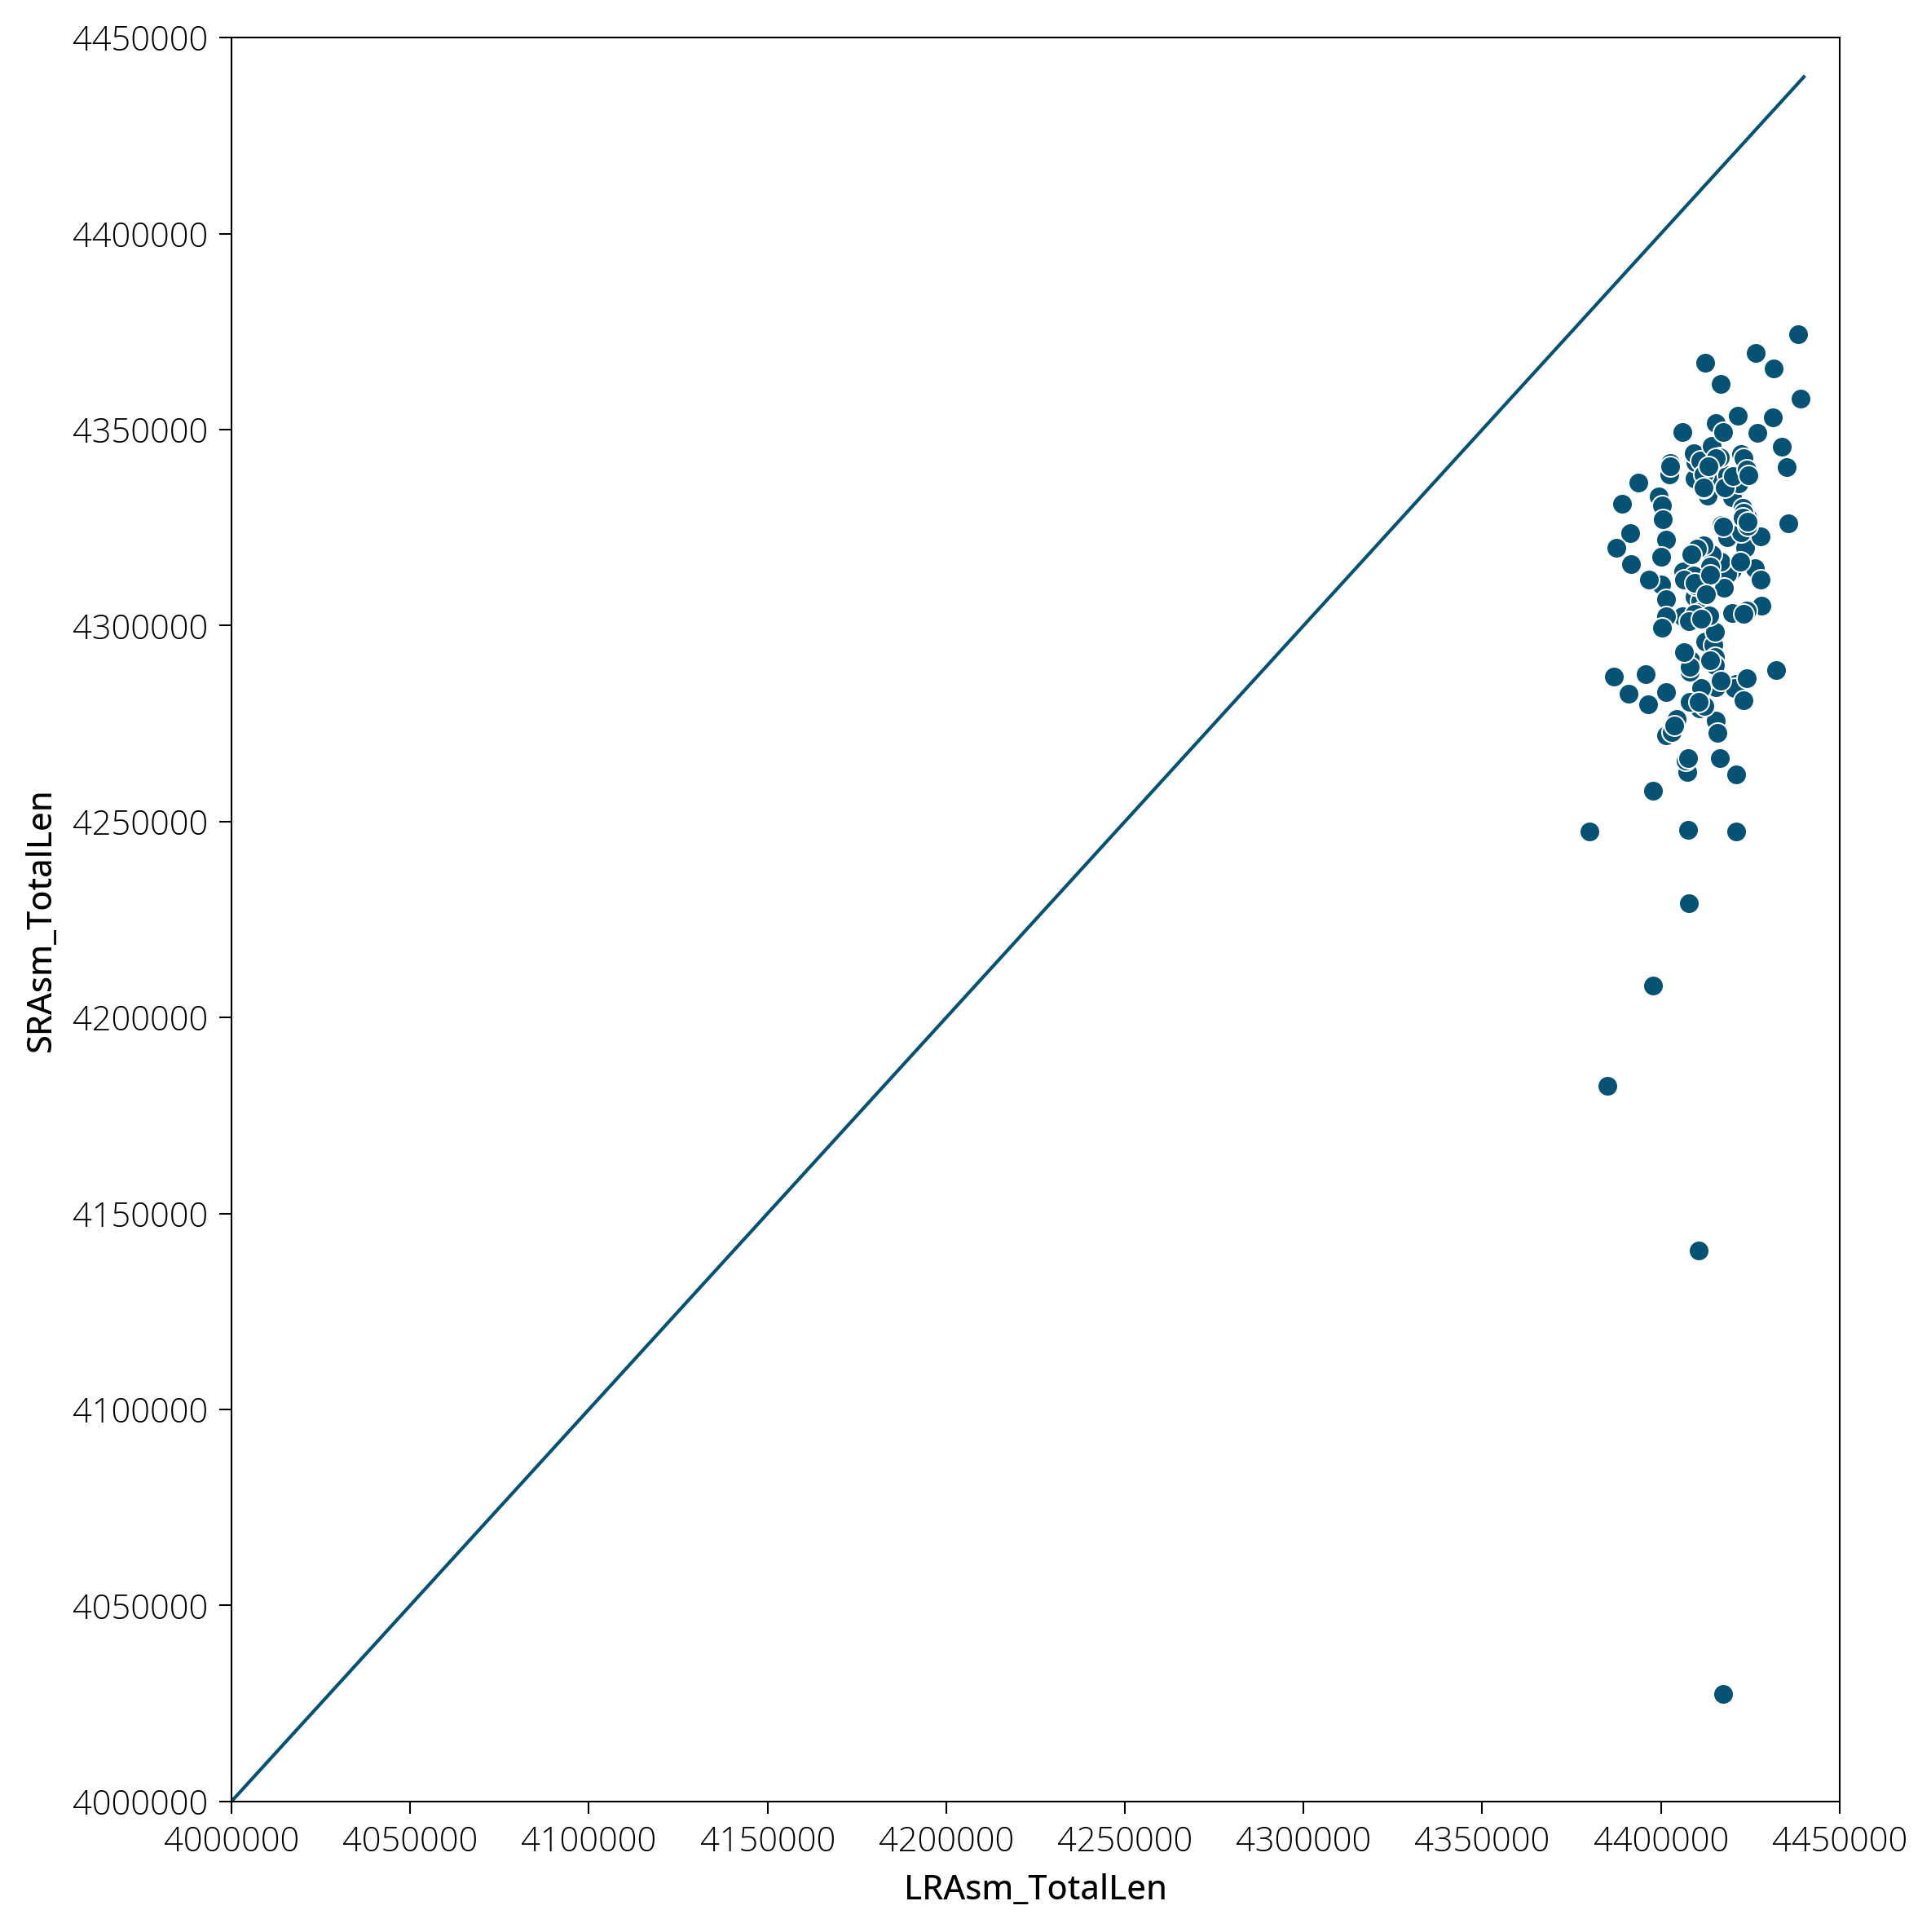

In [62]:
plt.figure(figsize = (8,8)  )

sns.scatterplot(x = "LRAsm_TotalLen", y = "SRAsm_TotalLen", data = WGA158CI_Asm_LRvsSR_DF)

x = np.linspace(0, 4440000, 1000)
plt.plot(x, x)

plt.xlim(4000000, 4450000)
plt.ylim(4000000, 4450000)

plt.show()

## 5) Number of CDSs - LR vs SR

In [63]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,4077.370861,18.989687,4020.0,4065.0,4074.0,4088.0,4135.0
ShortRead,151.0,4031.966887,25.823869,3862.0,4022.0,4035.0,4046.0,4080.0


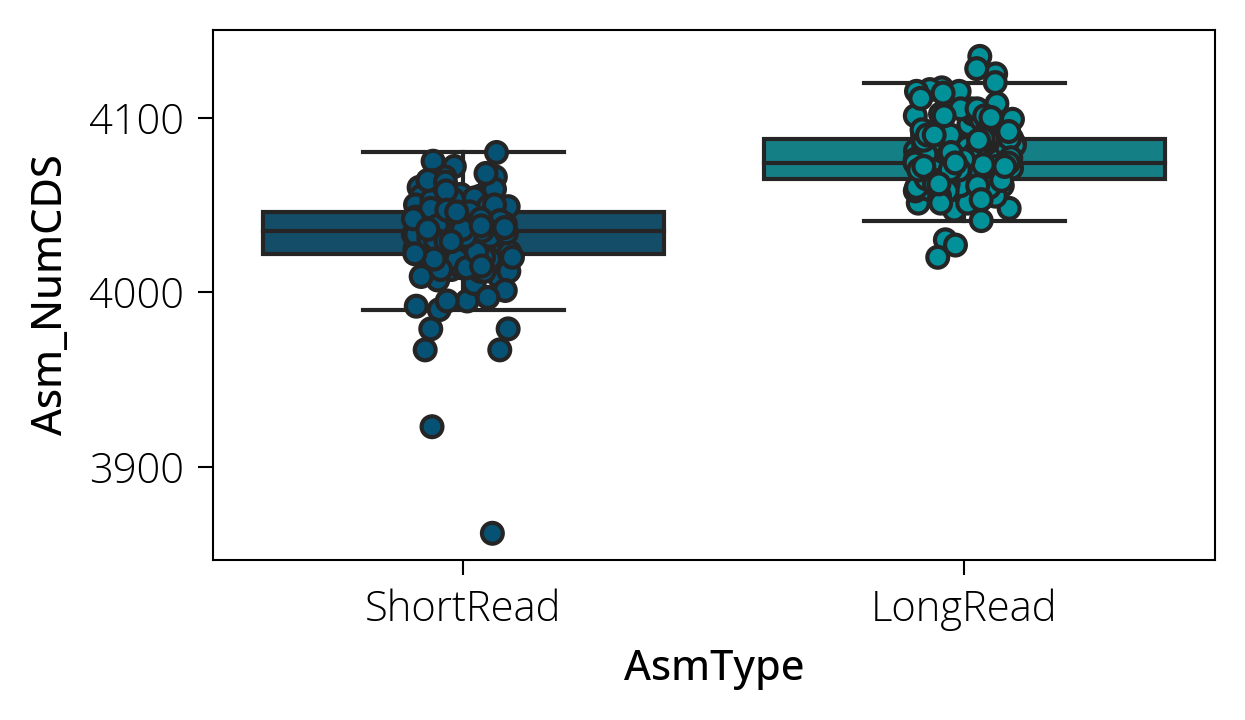

In [64]:
sns.boxplot(y = "Asm_NumCDS", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_NumCDS", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.show()


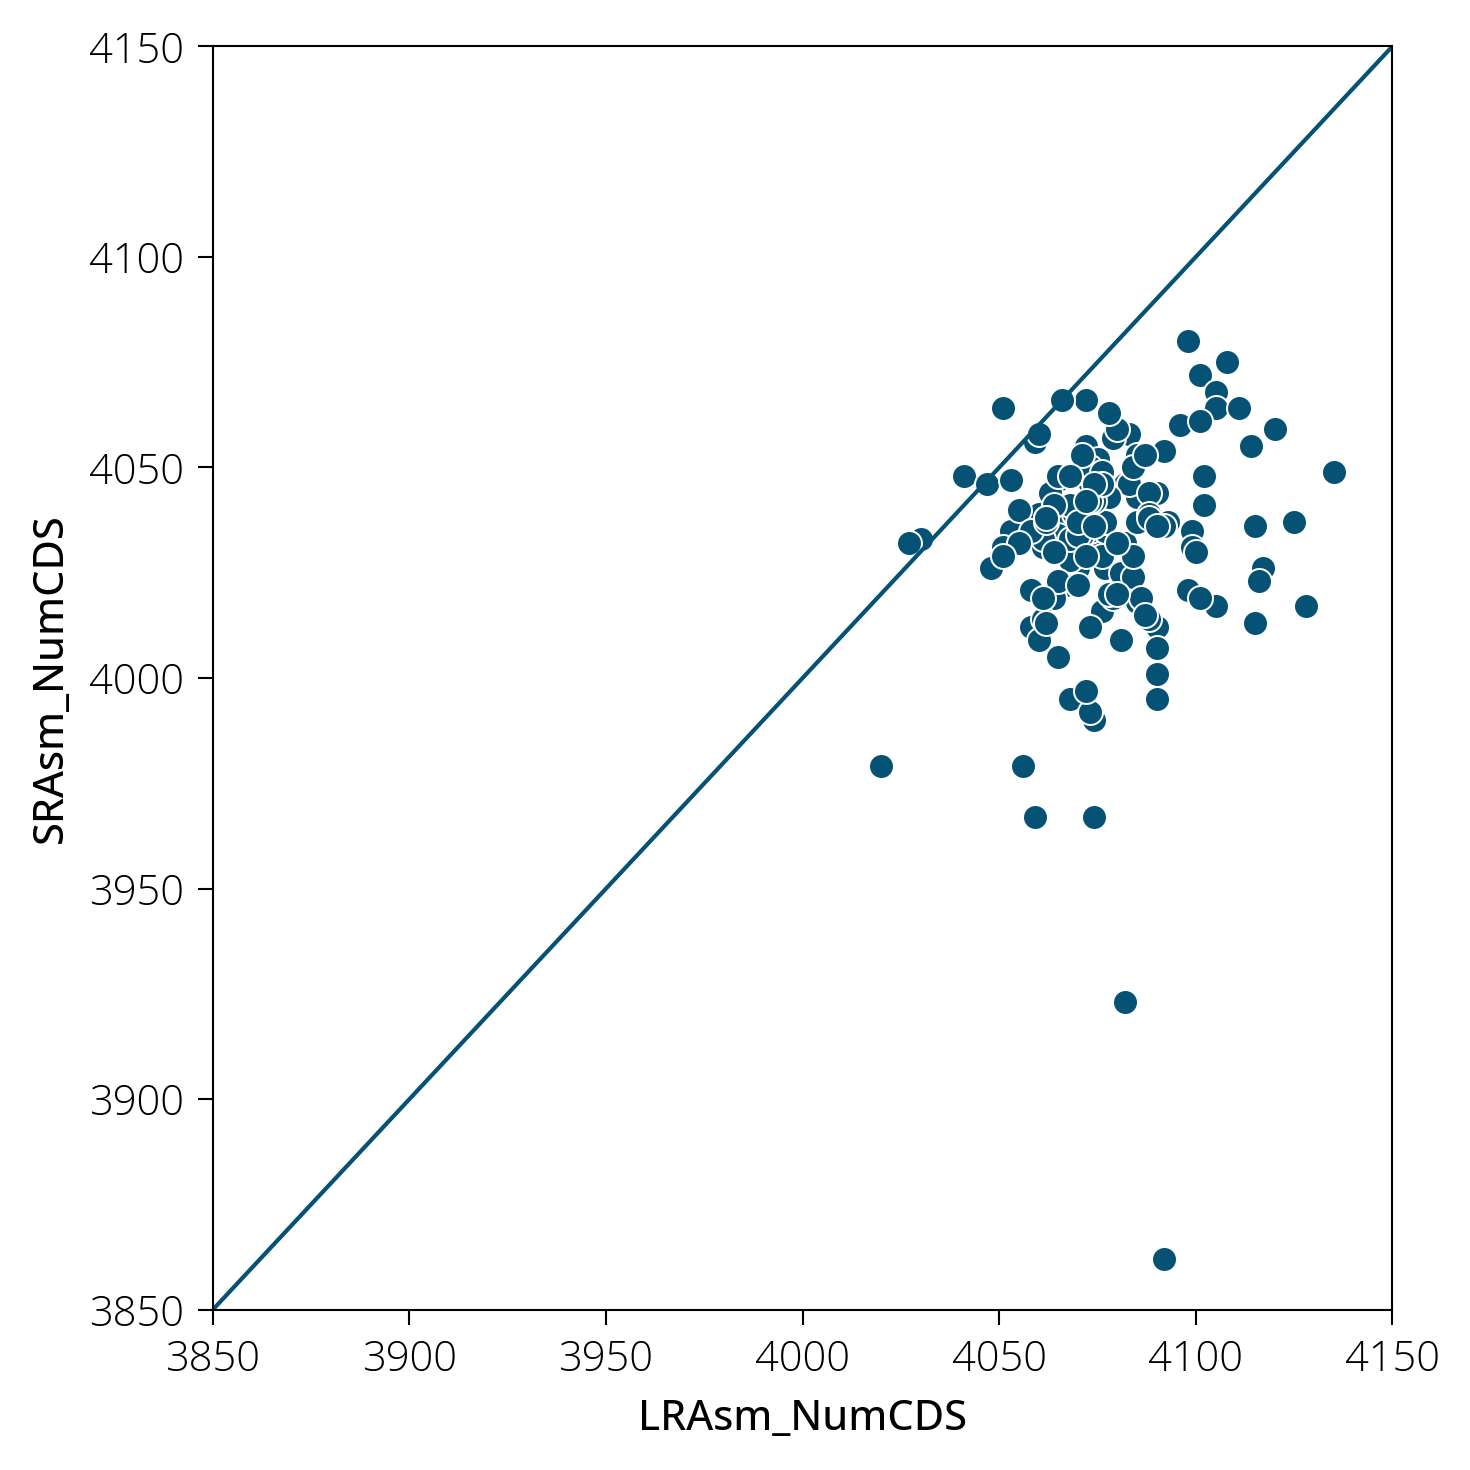

In [65]:
plt.figure(figsize = (5,5)  )

sns.scatterplot(x = "LRAsm_NumCDS", y = "SRAsm_NumCDS", data = WGA158CI_Asm_LRvsSR_DF)

x = np.linspace(0, 4440000, 1000)
plt.plot(x, x)

plt.xlim(3850, 4150)
plt.ylim(3850, 4150)

plt.show()

## 6) GC% - LR vs SR

In [66]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"]

,count,mean,std,min,25%,50%,75%,max
AsmType,,,,,,,,
LongRead,151.0,65.60000,2.851629e-14,65.6,65.6,65.6,65.6,65.6
ShortRead,151.0,65.52053,7.942953e-02,65.3,65.5,65.5,65.6,65.8


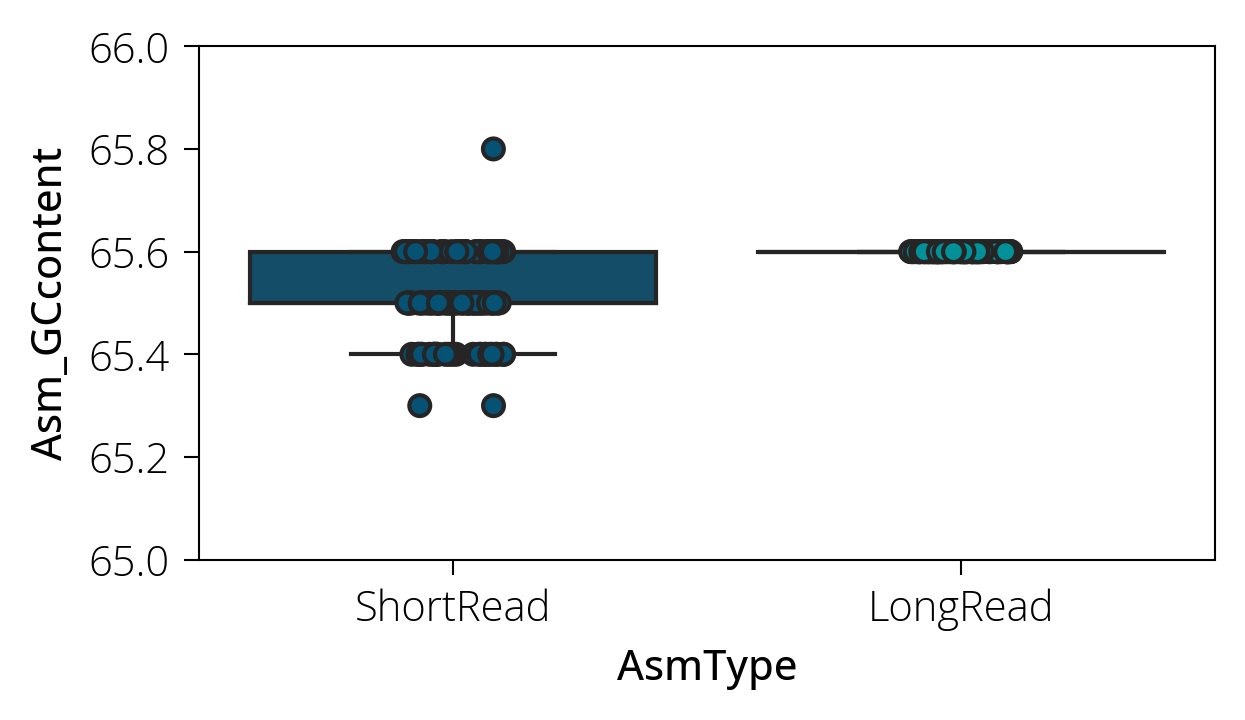

In [67]:
sns.boxplot(y = "Asm_GCcontent", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_GCcontent", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray' )
plt.ylim(65, 66)
plt.show()


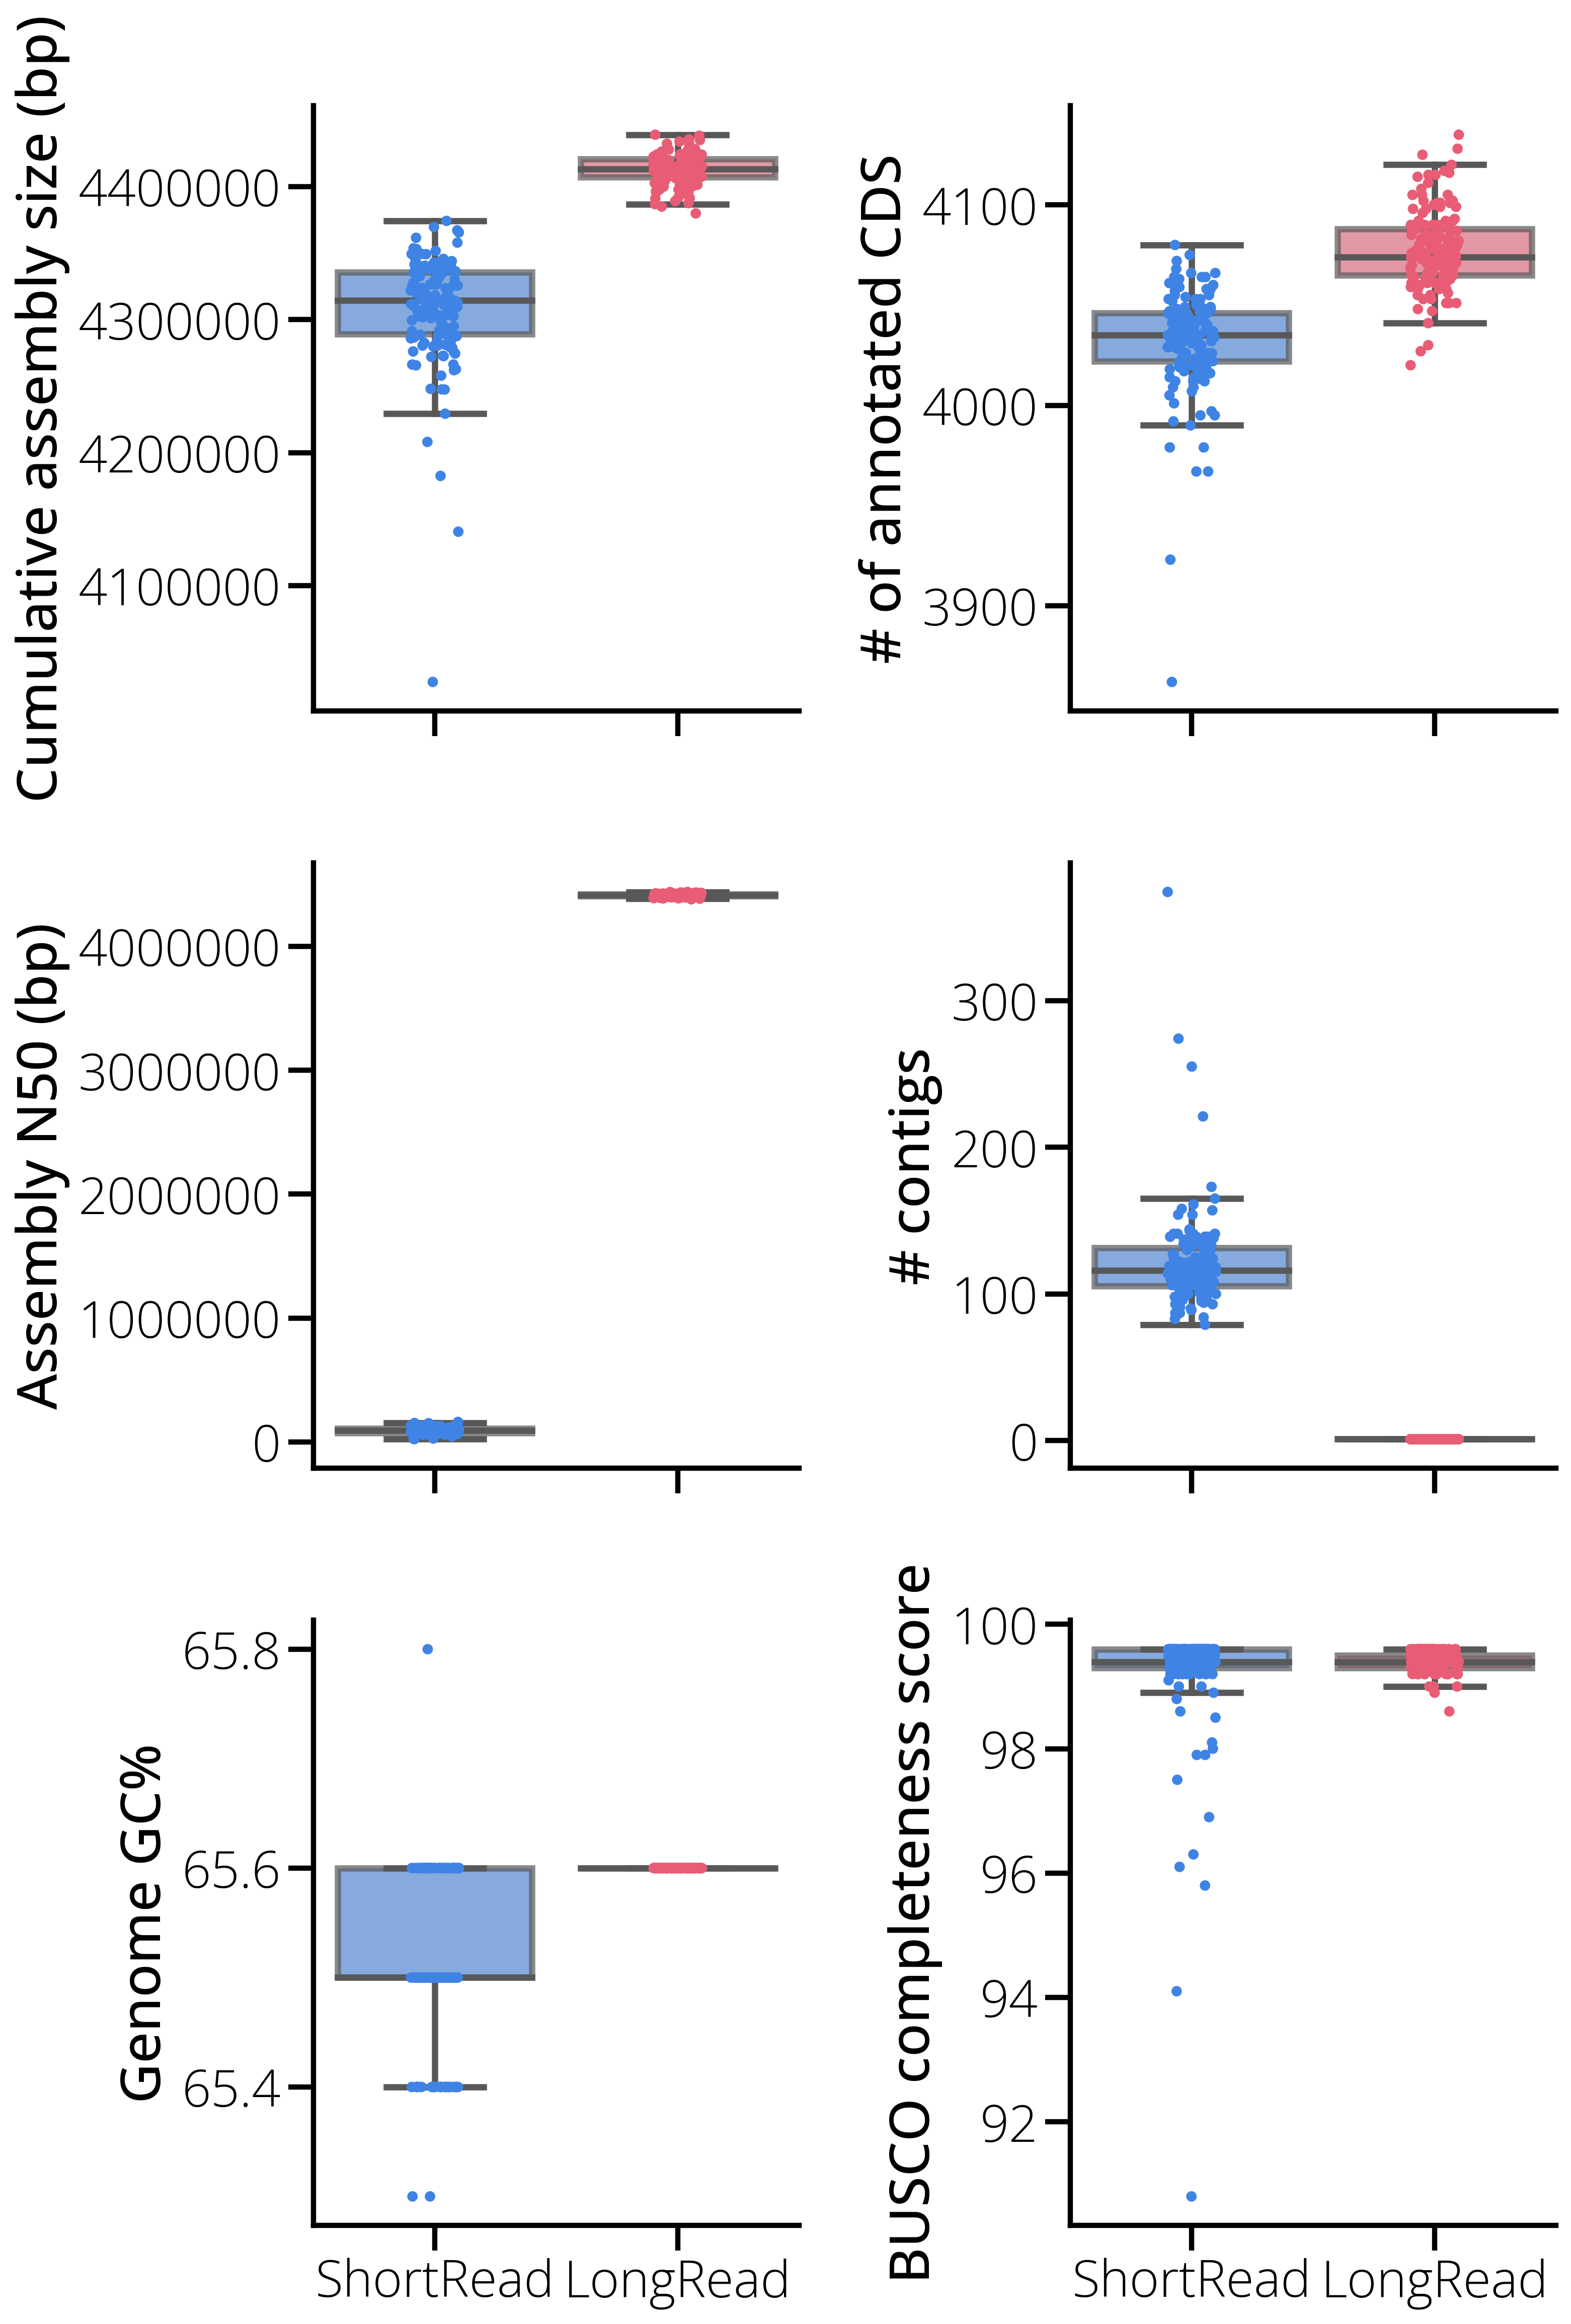

In [76]:
fig, axs = plt.subplots(3, 2, figsize= (11, 16), sharex=True)
#sns.set_context("paper")
#sns.set_context("paper", font_scale=2)
#sns.set_style(None)
sns.set_context("poster", font_scale=1.1)

#sns.set()

sns.boxplot(y = "Asm_TotalLen", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[0][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_TotalLen", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[0][0], palette = ["#3F84E5", "#E85D75"])
axs[0][0].set_ylabel("Cumulative assembly size (bp)")

sns.boxplot(y = "Asm_NumCDS", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[0][1], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_NumCDS", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[0][1], palette = ["#3F84E5", "#E85D75"])
axs[0][1].set_ylabel("# of annotated CDS")

sns.boxplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[1][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_N50", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[1][0], palette = ["#3F84E5", "#E85D75"])
axs[1][0].set_ylabel("Assembly N50 (bp)")

sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[1][1], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[1][1], palette = ["#3F84E5", "#E85D75"])
axs[1][1].set_ylabel("# contigs")

sns.boxplot(y = "Asm_GCcontent", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[2][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_GCcontent", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[2][0], palette = ["#3F84E5", "#E85D75"])
axs[2][0].set_ylabel("Genome GC%")

sns.boxplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
            fliersize=0, ax = axs[2][1], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Busco_Complete_Score", x = "AsmType", data = WGA158CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[2][1], palette = ["#3F84E5", "#E85D75"])
axs[2][1].set_ylabel("BUSCO completeness score")


axs[0][0].set_xlabel("")
axs[0][1].set_xlabel("")
axs[1][0].set_xlabel("")
axs[1][1].set_xlabel("")
axs[2][0].set_xlabel("")
axs[2][1].set_xlabel("")

#fig.suptitle('Complete vs Short Read assembly comparison: \n All 158 Mtb isolates ', fontsize=26)

sns.despine()

plt.savefig("Results1_Plots/S2.CompleteVsSR.AsmStats.png", dpi = 300)
plt.savefig("Results1_Plots/S2.CompleteVsSR.AsmStats.svg")

plt.show()


## Summarize LR vs SR metrics together (N = 151 isolates) - Table 1

In [69]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Busco_Complete_Score"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,99.3,99.4,99.5
ShortRead,99.3,99.4,99.6


In [70]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,4407115.5,4413185.0,4420762.0
ShortRead,4289080.5,4314468.0,4335781.0


In [71]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_Ncontigs"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,1.0,1.0,1.0
ShortRead,105.5,116.0,131.5


In [72]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_N50"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,4407115.5,4413185.0,4420762.0
ShortRead,73046.5,92078.0,107113.5


In [73]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,4065.0,4074.0,4088.0
ShortRead,4022.0,4035.0,4046.0


In [74]:
WGA158CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"][["25%","50%","75%"]]

,25%,50%,75%
AsmType,,,
LongRead,65.6,65.6,65.6
ShortRead,65.5,65.5,65.6


In [ ]:
STOP!

# Let's investigate the Low BUSCO score SR assemblies

In [ ]:
WGA158CI_Asm_LRvsSR_DF.head()

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").shape

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99")["Dataset_Tag"].value_counts()

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").sort_values("SRAsm_Busco_Complete_Score", ascending = True)

In [ ]:
WGA158CI_Asm_LRvsSR_DF.sort_values("SRAsm_Busco_Complete_Score", ascending = True).head(8)

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("LRAsm_Busco_Complete_Score < 99").sort_values("LRAsm_Busco_Complete_Score", ascending = True)

### Get SampleIDs associated w/ all isolates w/ a SR Asm BUSCO score >= 99.0

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99").shape

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99").shape

In [ ]:
High_SRBusco_SampleIDs_143CI = WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99")["SampleID"].values

In [ ]:
len(High_SRBusco_SampleIDs_143CI)

In [ ]:
High_SRBusco_SampleIDs_143CI

In [ ]:
WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score < 99")

In [ ]:
STOP!

# Making Figures - High BUSCO Isolates (140 isolates)

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF = WGA158CI_Asm_LRvsSR_TidyDF[WGA158CI_Asm_LRvsSR_TidyDF["SampleID"].isin(High_SRBusco_SampleIDs_143CI) ] 
HighBusco_143CI_Asm_LRvsSR_DF = WGA158CI_Asm_LRvsSR_DF.query("SRAsm_Busco_Complete_Score >= 99")


In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.shape

In [ ]:
HighBusco_143CI_Asm_LRvsSR_DF.shape

## 1) Busco Complete Score - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.head(1)

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Busco_Complete_Score"]

In [ ]:
sns.boxplot(y = "Busco_Complete_Score", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Busco_Complete_Score", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )

plt.axhline(y = 99.0, color = 'r', linestyle = '--')

plt.ylim(98, 100)
plt.show()

In [ ]:
plt.figure(figsize = (6,6)  )

sns.scatterplot(x = "LRAsm_Busco_Complete_Score", y = "SRAsm_Busco_Complete_Score", data = HighBusco_143CI_Asm_LRvsSR_DF)

x = np.linspace(0, 101, 1000)

plt.axhline(y = 99.0, color = 'r', linestyle = '--')
plt.axvline(x = 99.0, color = 'r', linestyle = '--')

plt.plot(x, x)

plt.xlim(98, 100)
plt.ylim(98, 100)

plt.show()

## 2) NumContigs - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_Ncontigs"]

In [ ]:
sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), fliersize=0)
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), linewidth=1, edgecolor='gray', )
plt.ylim(0, 500)
plt.show()

In [ ]:
sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
#plt.ylim(0, 400)
plt.show()

## 3) N50 - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_N50"]

In [ ]:
sns.boxplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), fliersize=0)
sns.stripplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF.query("AsmType == 'ShortRead'"), linewidth=1, edgecolor='gray', )
#plt.ylim(0, 5000000)
plt.show()

In [ ]:
sns.boxplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.ylim(0, 5000000)
plt.show()

## 4) Cumulative length of assembly - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"]

In [ ]:
sns.boxplot(y = "Asm_TotalLen", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_TotalLen", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.show()

In [ ]:
plt.figure(figsize = (12,12)  )

sns.scatterplot(x = "LRAsm_TotalLen", y = "SRAsm_TotalLen", data = HighBusco_143CI_Asm_LRvsSR_DF)

x = np.linspace(0, 4440000, 1000)
plt.plot(x, x)

plt.xlim(4000000, 4450000)
plt.ylim(4000000, 4450000)

plt.show()

## 5) Number of CDSs - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"]

In [ ]:
sns.boxplot(y = "Asm_NumCDS", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_NumCDS", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', )
plt.show()


In [ ]:
plt.figure(figsize = (5,5)  )

sns.scatterplot(x = "LRAsm_NumCDS", y = "SRAsm_NumCDS", data = HighBusco_143CI_Asm_LRvsSR_DF)

x = np.linspace(0, 4440000, 1000)
plt.plot(x, x)

plt.xlim(3850, 4150)
plt.ylim(3850, 4150)

plt.show()

## 6) GC% - LR vs SR

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"]

In [ ]:
sns.boxplot(y = "Asm_GCcontent", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0)
sns.stripplot(y = "Asm_GCcontent", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray' )
plt.ylim(65, 66)
plt.show()


In [ ]:
fig, axs = plt.subplots(3, 2, figsize= (25, 15))
#sns.set_context("paper")
sns.set_context("talk")

sns.boxplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[0][0], palette = ["#3F84E5", "#E85D75"])
sns.stripplot(y = "Asm_N50", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[0][0], palette = ["#3F84E5", "#E85D75"])
axs[0][0].set_ylabel("Assembly N50 (bp)")

sns.boxplot(y = "Asm_TotalLen", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[0][1], palette = ["#3F84E5", "#E85D75"])
sns.stripplot(y = "Asm_TotalLen", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[0][1], palette = ["#3F84E5", "#E85D75"])
axs[0][1].set_ylabel("Cumulative assembly size (bp)")

sns.boxplot(y = "Asm_NumCDS", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[1][0], palette = ["#3F84E5", "#E85D75"])
sns.stripplot(y = "Asm_NumCDS", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[1][0], palette = ["#3F84E5", "#E85D75"])
axs[1][0].set_ylabel("# of annotated CDS")

sns.boxplot(y = "Asm_GCcontent", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[1][1], palette = ["#3F84E5", "#E85D75"])
sns.stripplot(y = "Asm_GCcontent", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[1][1], palette = ["#3F84E5", "#E85D75"])
axs[1][1].set_ylabel("GC content")

sns.boxplot(y = "Busco_Complete_Score", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[2][0], palette = ["#3F84E5", "#E85D75"]
sns.stripplot(y = "Busco_Complete_Score", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[2][0], palette = ["#3F84E5", "#E85D75"])
axs[2][0].set_ylabel("BUSCO complete score")

sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, fliersize=0, ax = axs[2][1], palette = ["#3F84E5", "#E85D75"])
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = HighBusco_143CI_Asm_LRvsSR_TidyDF, linewidth=1, edgecolor='gray', ax = axs[2][1], palette = ["#3F84E5", "#E85D75"])

axs[2][1].set_ylabel("# contigs")

axs[0][0].set_xlabel("")
axs[0][1].set_xlabel("")
axs[1][0].set_xlabel("")
axs[1][1].set_xlabel("")
axs[2][0].set_xlabel("")
axs[2][1].set_xlabel("")

fig.suptitle('HIGH SR Asm BUSCO Mtb isolates (N = 143) ', fontsize=26)

sns.despine()
plt.show()

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Busco_Complete_Score"]

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"]

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_Ncontigs"]

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_N50"]

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"]

In [ ]:
HighBusco_143CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"]

## Extras

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.query("Lineage_coll2014 == 'lineage8'")

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.sort_values("Busco_Complete_Score").head(6)

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.sort_values("Busco_Complete_Score").tail(6)

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Busco_Complete_Score"]

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_TotalLen"]

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_Ncontigs"]

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_N50"]

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_NumCDS"]

In [ ]:
HighBusco_140CI_Asm_LRvsSR_TidyDF.groupby("AsmType").describe()["Asm_GCcontent"]